#Setup Environment

In [ ]:
from google.colab import drive

import numpy as np

import pandas as pd

from scipy.stats import chi2_contingency, pointbiserialr, randint, uniform, ttest_ind,  spearmanr
from scipy.stats.contingency import association

import seaborn as sns

import shap

from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
  classification_report,
  PrecisionRecallDisplay,
  RocCurveDisplay,
)
from sklearn.model_selection import (
  cross_val_score,
  train_test_split,
  RandomizedSearchCV,
)
from sklearn.preprocessing import (
  LabelEncoder,
  RobustScaler,
  OneHotEncoder,
  OrdinalEncoder,
)

import xgboost as xgb

from tabulate import tabulate

from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
HEX_BLUE = '#48a8c4'
HEX_RED = '#c0504d'
pd.set_option('display.max_columns', 100)

#Import Data

In [ ]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
project_dir = '/gdrive/My Drive/Colab Notebooks/Day 9 Extra Class Feature Importance Analysis & Model Interpretation/Assignment/'

In [ ]:
df = pd.read_csv(project_dir + 'bank_churn_data.csv')
df.shape

(10127, 21)

In [ ]:
df.sample(3)

user_id     attrition_flag  customer_age gender  dependent_count  \
5950  718596858  Existing Customer            53      F                4   
3677  716461683  Existing Customer            47      F                3   
9131  815078433  Existing Customer            42      F                4   

     education_level marital_status income_category card_category  \
5950        Graduate       Divorced     $40K - $60K          Blue   
3677      Uneducated        Married  Less than $40K        Silver   
9131         Unknown        Married  Less than $40K          Blue   

      months_on_book  total_relationship_count  months_inactive_12_mon  \
5950              45                         5                       3   
3677              36                         5                       3   
9131              37                         2                       1   

      contacts_count_12_mon  credit_limit  total_revolving_bal  \
5950                      1        3369.0                 2424   
3677                      1       11884.0                 1339   
9131                      3        6551.0                 1718   

      avg_open_to_buy  total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
5950            945.0                 0.825             5220              78   
3677          10545.0                 0.556             4134              72   
9131           4833.0                 1.207            13363              99   

      total_ct_chng_q4_q1  avg_utilization_ratio  
5950                0.592                  0.720  
3677                1.000                  0.113  
9131                0.623                  0.262

#Data Preprocessing

##Missing Value

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

In [ ]:
df.isna().sum()

user_id                     0
attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

#Cek Duplikat

In [ ]:
df.duplicated().sum()

np.int64(0)

#EDA

##Adjust Churn Column

In [ ]:
# create churn feature
if 'churn' not in df.columns:
    if 'attrition_flag' in df.columns:
        df['churn'] = df['attrition_flag'].apply(lambda x: 1 if str(x).strip().lower() != 'existing customer' else 0)
    else:
        raise ValueError("No attrition_flag or churn column found.")
print("Value counts churn:")
print(df['churn'].value_counts(normalize=True))

Value counts churn:
churn
0    0.83934
1    0.16066
Name: proportion, dtype: float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

##Business Questions

Seperti apa distribusi usia para nasabah? Usia manakah yang cenderung memiliki
kemungkinan churn terbesar?

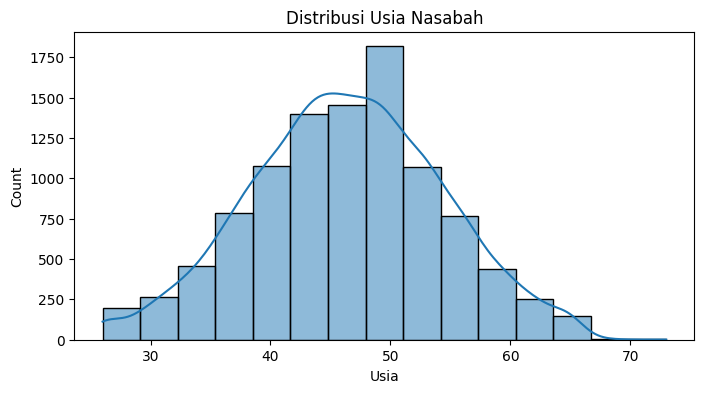

/tmp/ipython-input-3818860686.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn = df.groupby('age_group')['churn'].agg(['mean','count']).reset_index()


age_group      mean  count  mean_pct
0     18-29  0.087179    195      8.72
1     30-39  0.141771   1841     14.18
2     40-49  0.169261   4561     16.93
3     50-59  0.168779   2998     16.88
4       60+  0.133459    532     13.35

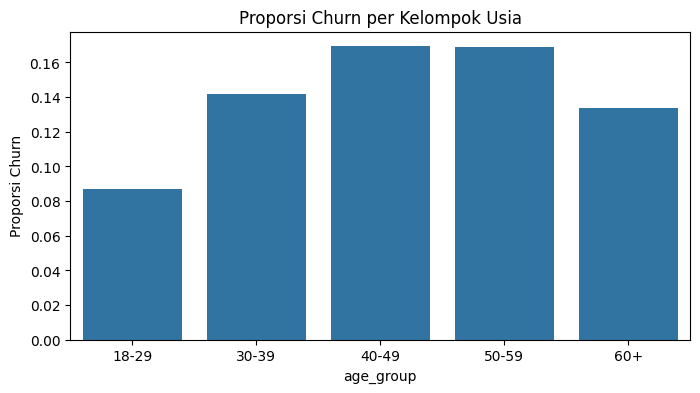

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['customer_age'].dropna(), bins=15, kde=True)
plt.title('Distribusi Usia Nasabah')
plt.xlabel('Usia')
plt.show()

bins = [18,30,40,50,60,100]
labels = ['18-29','30-39','40-49','50-59','60+']
df['age_group'] = pd.cut(df['customer_age'], bins=bins, labels=labels, right=False)

age_churn = df.groupby('age_group')['churn'].agg(['mean','count']).reset_index()
age_churn['mean_pct'] = (age_churn['mean']*100).round(2)
display(age_churn)

plt.figure(figsize=(8,4))
sns.barplot(data=age_churn, x='age_group', y='mean')
plt.ylabel('Proporsi Churn')
plt.title('Proporsi Churn per Kelompok Usia')
plt.show()

Usia dengan kelompok 40 -59 adalah 2 kelompok yang potensi churnnya paling tingi/besar

Apakah terdapat korelasi antara tingkat pendidikan dan income category?
Bagaimana korelasi dari kedua prediktor tersebut terhadap churn?

Cramer's V education vs income: 0.03

 education_level


mean  count
education_level                 
Doctorate        0.210643    451
Post-Graduate    0.178295    516
Unknown          0.168532   1519
Uneducated       0.159381   1487
Graduate         0.155691   3128
College          0.152024   1013
High School      0.152012   2013

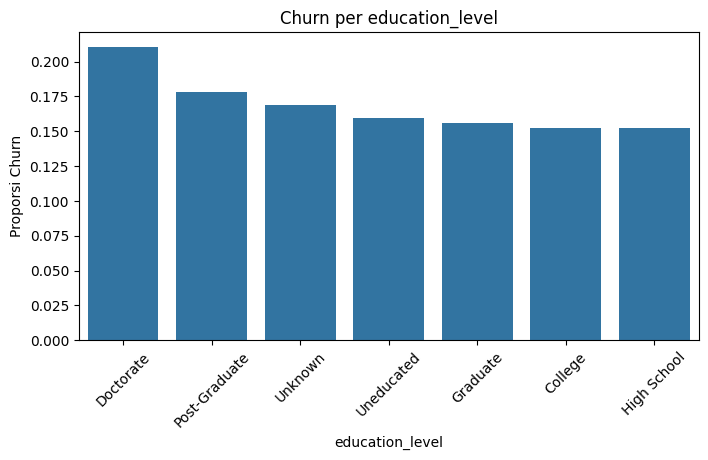


 income_category


mean  count
income_category                 
$120K +          0.173315    727
Less than $40K   0.171862   3561
Unknown          0.168165   1112
$80K - $120K     0.157655   1535
$40K - $60K      0.151397   1790
$60K - $80K      0.134807   1402

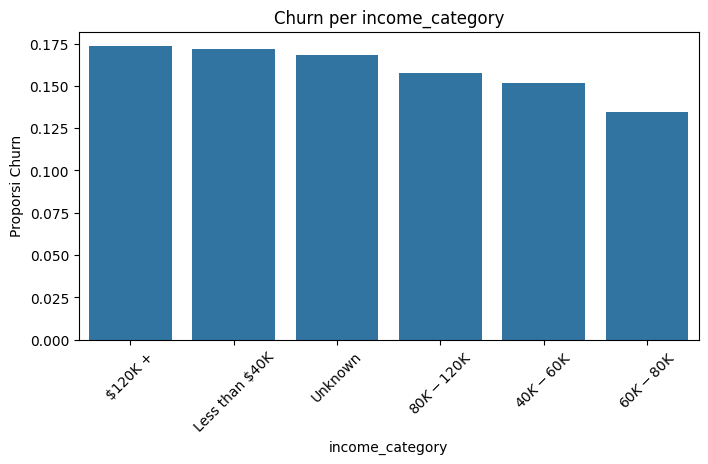

In [ ]:
def cramers_v(x, y):
    confusion = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2/n
    r,k = confusion.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Cramer's V
cv = cramers_v(df['education_level'], df['income_category'])
print("Cramer's V education vs income:", round(cv,3))

# Proporsi churn per kategori pendidikan & income
for col in ['education_level','income_category']:
    temp = df.groupby(col)['churn'].agg(['mean','count']).sort_values('mean',ascending=False)
    print("\n", col)
    display(temp.head(10))
    plt.figure(figsize=(8,4))
    sns.barplot(x=temp.index, y=temp['mean'])
    plt.xticks(rotation=45)
    plt.ylabel('Proporsi Churn')
    plt.title(f'Churn per {col}')
    plt.show()

Jika dari tingkat pendidikan potensi churnnya lebih tinggi di level Doctorate.

Tingkat pendidikan lebih tinggi tidak otomatis berarti churn lebih rendah, justru di sini nasabah berpendidikan tinggi cenderung churn lebih banyak.

Begitu juga dari kategori pendapatan, pendapatan yg paling tinggi lebih berpotensi churn lebih besar, mungkin bisa dikarenakan mengharapkan layanan better dan lainnya.

Apakah terdapat perbedaan yang signifikan antara gender dengan kemungkinan
nasabah untuk churn?

churn      0    1
gender           
F       4428  930
M       4072  697

Chi-square p-value: 0.00019635846717310307


prop  count  success
gender                          
F       0.173572   5358      930
M       0.146152   4769      697

Proportions z-test p-value: 0.00017629768002806333


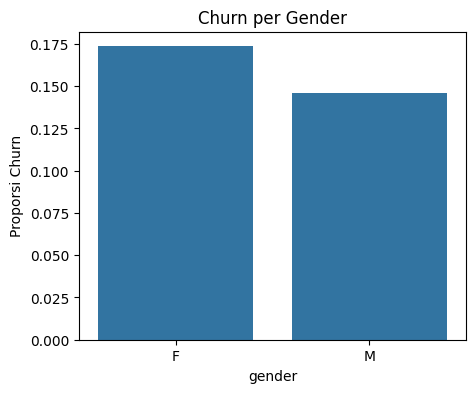

In [ ]:
if 'gender' in df.columns:
    ct = pd.crosstab(df['gender'], df['churn'])
    display(ct)
    chi2, p, _, _ = chi2_contingency(ct)
    print("Chi-square p-value:", p)
    prop = df.groupby('gender')['churn'].mean()
    counts = df.groupby('gender')['churn'].count()
    success = df.groupby('gender')['churn'].sum()
    display(pd.DataFrame({'prop':prop, 'count':counts, 'success':success}))
    if len(prop)==2:
        stat, pval = proportions_ztest(success.values, counts.values)
        print("Proportions z-test p-value:", pval)
    plt.figure(figsize=(5,4))
    sns.barplot(x=prop.index, y=prop.values)
    plt.title('Churn per Gender')
    plt.ylabel('Proporsi Churn')
    plt.show()
else:
    print("gender not present")

Jika perbandingan antara gender tidak mempunyai perbedaan yang signifikan gender mana yang mendominasi untuk potensi churn

Apakah semakin lama customer menjadi nasabah maka semakin kecil
kemungkinan nasabah tersebut untuk churn?

/tmp/ipython-input-1857876935.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure = df.groupby('tenure_bin')['churn'].agg(['mean','count']).reset_index()


tenure_bin      mean  count
0     [0, 6)       NaN      0
1    [6, 12)       NaN      0
2   [12, 24)  0.142649    687
3   [24, 36)  0.150562   3115
4   [36, 48)  0.167393   5508
5   [48, 60)  0.168911    817
6  [60, 200)       NaN      0

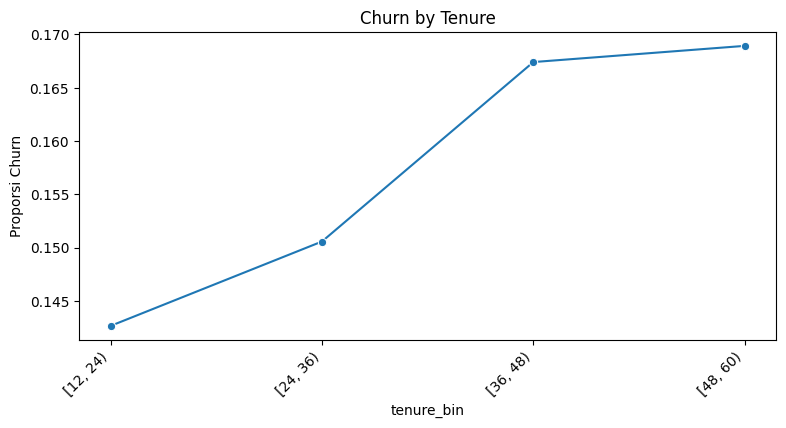

Spearman corr: 0.015299580450874529 p: 0.12367186812277864


In [ ]:
if 'months_on_book' in df.columns:
    df['tenure_bin'] = pd.cut(df['months_on_book'], bins=[0,6,12,24,36,48,60,200], right=False)
    tenure = df.groupby('tenure_bin')['churn'].agg(['mean','count']).reset_index()
    display(tenure)
    plt.figure(figsize=(9,4))
    sns.lineplot(x=tenure['tenure_bin'].astype(str), y=tenure['mean'], marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.title('Churn by Tenure')
    plt.ylabel('Proporsi Churn')
    plt.show()
    corr, p = spearmanr(df['months_on_book'].fillna(0), df['churn'])
    print("Spearman corr:", corr, "p:", p)
else:
    print("months_on_book not present")

Semakin lama menjadi nasabah maka akan semakin besar untuk potensi untuk churn.

Apakah semakin sering customer berinteraksi dengan bank dalam 1 tahun
terakhir mempengaruhi besar atau kecilnya kemungkinan nasabah untuk churn?

/tmp/ipython-input-2741701749.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contacts = df.groupby('contacts_bin')['churn'].agg(['mean','count']).reset_index()


contacts_bin      mean  count
0      (-1, 0]  0.017544    399
1       (0, 1]  0.072048   1499
2       (1, 2]  0.124884   3227
3       (2, 3]  0.201479   3380
4     (3, 100]  0.263872   1622

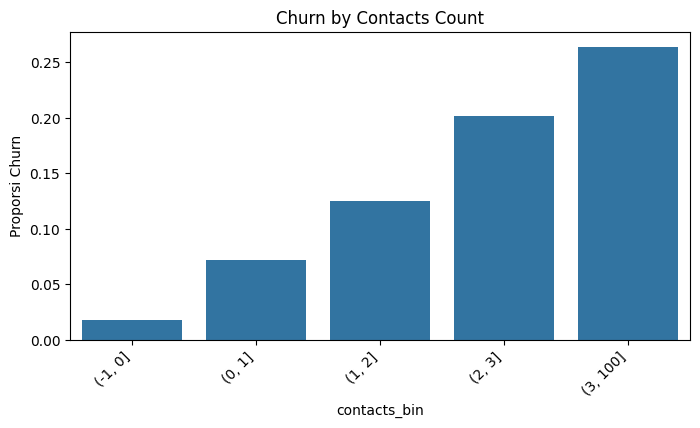

Spearman corr: 0.18903770002956655 p: 4.1233624715763304e-82


In [ ]:
if 'contacts_count_12_mon' in df.columns:
    df['contacts_bin'] = pd.cut(df['contacts_count_12_mon'], bins=[-1,0,1,2,3,100], right=True)
    contacts = df.groupby('contacts_bin')['churn'].agg(['mean','count']).reset_index()
    display(contacts)
    plt.figure(figsize=(8,4))
    sns.barplot(x=contacts['contacts_bin'].astype(str), y=contacts['mean'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Churn by Contacts Count')
    plt.ylabel('Proporsi Churn')
    plt.show()
    corr_c, p_c = spearmanr(df['contacts_count_12_mon'].fillna(0), df['churn'])
    print("Spearman corr:", corr_c, "p:", p_c)
else:
    print("contacts_count_12_mon not present")

Semakin jarang nasabah melakukan kontak dengan bank, maka potensi untuk churn juga akan semakin besar

##Data Distribution

In [ ]:
target_column = 'churn'

numerical_cols = [
    'customer_age',
    'dependent_count',
    'months_on_book',
    'total_relationship_count',
    'months_inactive_12_mon',
    'contacts_count_12_mon',
    'credit_limit',
    'total_revolving_bal',
    'avg_open_to_buy',
    'total_amt_chng_q4_q1',
    'total_trans_amt',
    'total_trans_ct',
    'total_ct_chng_q4_q1',
    'avg_utilization_ratio'
]

categorical_cols = [
    'gender',
    'education_level',
    'marital_status',
    'income_category',
    'card_category'
]

In [ ]:
df.groupby(target_column).size()

churn
0    8500
1    1627
dtype: int64

In [ ]:
1627 / (8500+1627)

0.1606596227905599

###Category

In [ ]:
def show_relationship_category_category(series1,
                                        series2,
                                        positive_class=None,
                                        return_result=False):
  df_temp = pd.crosstab(series1, series2)

  res = chi2_contingency(df_temp)
  coef = round(association(df_temp, method='cramer'), 2)

  if positive_class:
    df_temp[str(positive_class) + '_proba'] = \
      df_temp[positive_class] / (df_temp.sum(axis=1))

  if return_result:
    return (round(res.pvalue, 4), coef)

  print(series1.name, 'vs', series2.name)
  print('Chi2 Test p-Value      :', round(res.pvalue, 4))
  print('Cramer\'s V Coefficient :', coef)
  print(tabulate(
    df_temp,
    headers='keys',
    floatfmt=[''] + [',.0f'] * series2.unique().shape[0] + ['.1%'],
  ))

In [ ]:
show_relationship_category_category(
  df['gender'],
  df['attrition_flag'],
  positive_class='Attrited Customer',
)

gender vs attrition_flag
Chi2 Test p-Value      : 0.0002
Cramer's V Coefficient : 0.04
gender      Attrited Customer    Existing Customer    Attrited Customer_proba
--------  -------------------  -------------------  -------------------------
F                         930                4,428                      17.4%
M                         697                4,072                      14.6%


In [ ]:
show_relationship_category_category(
  df['education_level'],
  df['attrition_flag'],
  positive_class='Attrited Customer',
)

education_level vs attrition_flag
Chi2 Test p-Value      : 0.0515
Cramer's V Coefficient : 0.04
education_level      Attrited Customer    Existing Customer    Attrited Customer_proba
-----------------  -------------------  -------------------  -------------------------
College                            154                  859                      15.2%
Doctorate                           95                  356                      21.1%
Graduate                           487                2,641                      15.6%
High School                        306                1,707                      15.2%
Post-Graduate                       92                  424                      17.8%
Uneducated                         237                1,250                      15.9%
Unknown                            256                1,263                      16.9%


In [ ]:
show_relationship_category_category(
  df['marital_status'],
  df['attrition_flag'],
  positive_class='Attrited Customer',
)

marital_status vs attrition_flag
Chi2 Test p-Value      : 0.1089
Cramer's V Coefficient : 0.02
marital_status      Attrited Customer    Existing Customer    Attrited Customer_proba
----------------  -------------------  -------------------  -------------------------
Divorced                          121                  627                      16.2%
Married                           709                3,978                      15.1%
Single                            668                3,275                      16.9%
Unknown                           129                  620                      17.2%


In [ ]:
show_relationship_category_category(
  df['income_category'],
  df['attrition_flag'],
  positive_class='Attrited Customer',
)

income_category vs attrition_flag
Chi2 Test p-Value      : 0.025
Cramer's V Coefficient : 0.04
income_category      Attrited Customer    Existing Customer    Attrited Customer_proba
-----------------  -------------------  -------------------  -------------------------
$120K +                            126                  601                      17.3%
$40K - $60K                        271                1,519                      15.1%
$60K - $80K                        189                1,213                      13.5%
$80K - $120K                       242                1,293                      15.8%
Less than $40K                     612                2,949                      17.2%
Unknown                            187                  925                      16.8%


In [ ]:
show_relationship_category_category(
  df['card_category'],
  df['attrition_flag'],
  positive_class='Attrited Customer',
)

card_category vs attrition_flag
Chi2 Test p-Value      : 0.5252
Cramer's V Coefficient : 0.01
card_category      Attrited Customer    Existing Customer    Attrited Customer_proba
---------------  -------------------  -------------------  -------------------------
Blue                           1,519                7,917                      16.1%
Gold                              21                   95                      18.1%
Platinum                           5                   15                      25.0%
Silver                            82                  473                      14.8%


###Numeric

In [ ]:
def show_relationship_numeric_category(series_numeric,
                                       series_category,
                                       return_result=False):
  if series_category.unique().shape[0] > 2:
    series_numeric_category = pd.qcut(series_numeric, 4, duplicates='drop')
    res = show_relationship_category_category(
      series_numeric_category,
      series_category,
      return_result=return_result,
    )
    if return_result:
      return res
  else:
    val_0 = series_category.min()
    val_1 = series_category.max()
    res = pointbiserialr(series_category == val_1, series_numeric)

    if return_result:
      return round(res.pvalue, 2), round(res.statistic, 2)

    print(series_numeric.name, 'vs', series_category.name)
    print('Point Biserial p-Value     :', round(res.pvalue, 2))
    print('Point Biserial Coefficient :', round(res.statistic, 2))
    sns.violinplot(
      x=series_numeric,
      hue=series_category,
      split=True,
      inner='quart',
      gap=0.1,
      palette='muted',
    )

customer_age vs attrition_flag
Point Biserial p-Value     : 0.07
Point Biserial Coefficient : -0.02


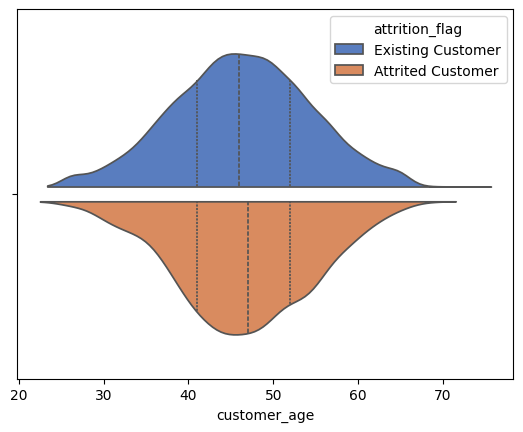

In [ ]:
show_relationship_numeric_category(
    df['customer_age'],
    df['attrition_flag'],
)

dependent_count vs attrition_flag
Point Biserial p-Value     : 0.06
Point Biserial Coefficient : -0.02


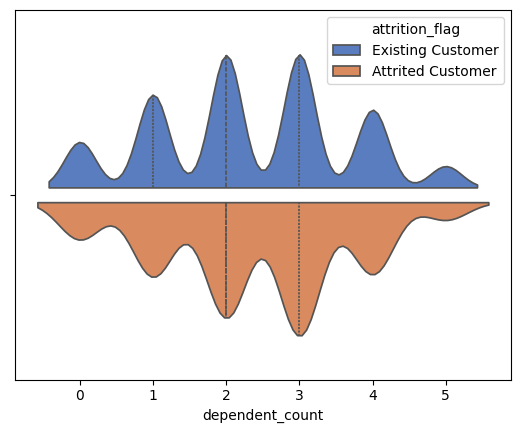

In [ ]:
show_relationship_numeric_category(
    df['dependent_count'],
    df['attrition_flag'],
)

months_on_book vs attrition_flag
Point Biserial p-Value     : 0.17
Point Biserial Coefficient : -0.01


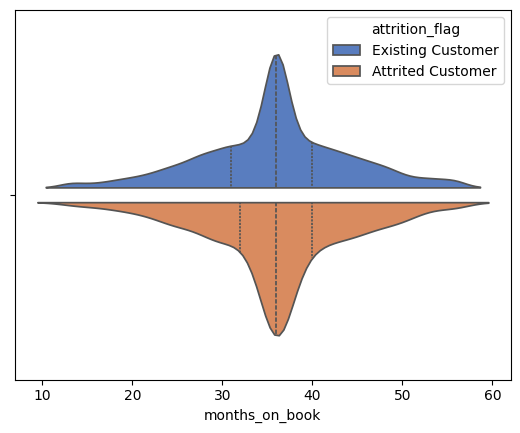

In [ ]:
show_relationship_numeric_category(
    df['months_on_book'],
    df['attrition_flag'],
)

total_relationship_count vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.15


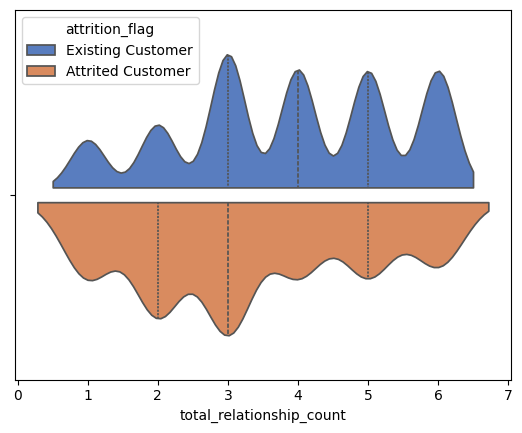

In [ ]:
show_relationship_numeric_category(
    df['total_relationship_count'],
    df['attrition_flag'],
)

months_inactive_12_mon vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : -0.15


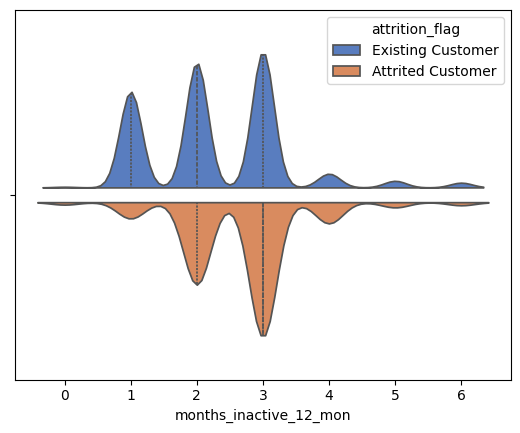

In [ ]:
show_relationship_numeric_category(
    df['months_inactive_12_mon'],
    df['attrition_flag'],
)

contacts_count_12_mon vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : -0.2


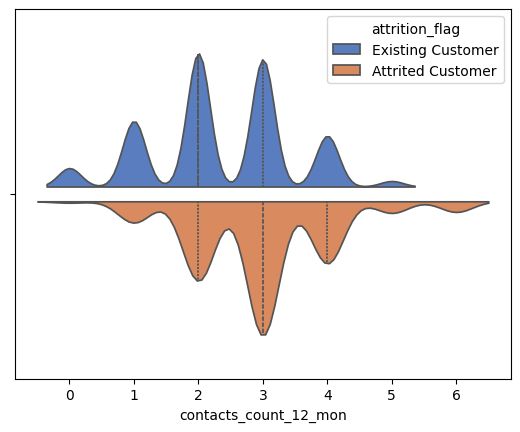

In [ ]:
show_relationship_numeric_category(
    df['contacts_count_12_mon'],
    df['attrition_flag'],
)

credit_limit vs attrition_flag
Point Biserial p-Value     : 0.02
Point Biserial Coefficient : 0.02


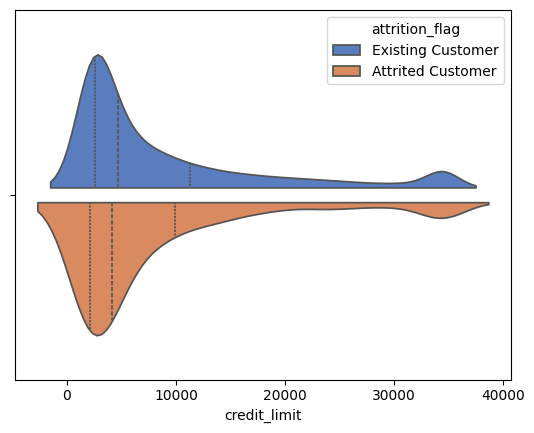

In [ ]:
show_relationship_numeric_category(
    df['credit_limit'],
    df['attrition_flag'],
)

total_revolving_bal vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.26


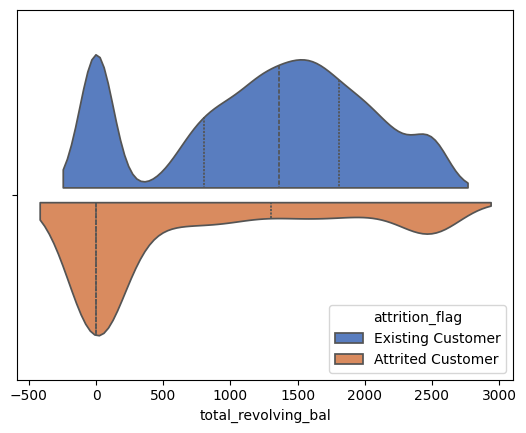

In [ ]:
show_relationship_numeric_category(
    df['total_revolving_bal'],
    df['attrition_flag'],
)

avg_open_to_buy vs attrition_flag
Point Biserial p-Value     : 0.98
Point Biserial Coefficient : 0.0


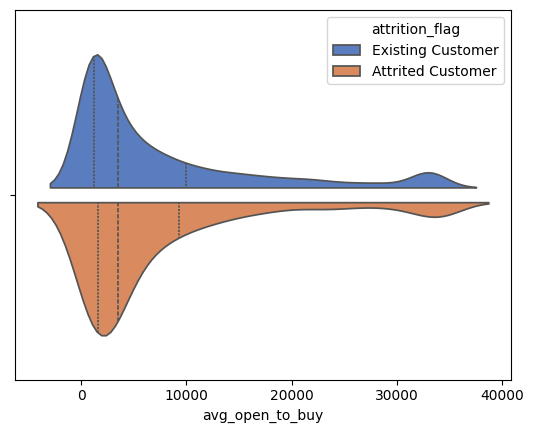

In [ ]:
show_relationship_numeric_category(
    df['avg_open_to_buy'],
    df['attrition_flag'],
)

total_amt_chng_q4_q1 vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.13


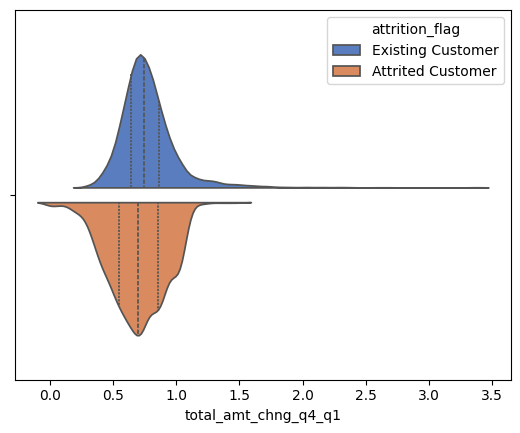

In [ ]:
show_relationship_numeric_category(
    df['total_amt_chng_q4_q1'],
    df['attrition_flag'],
)

total_trans_amt vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.17


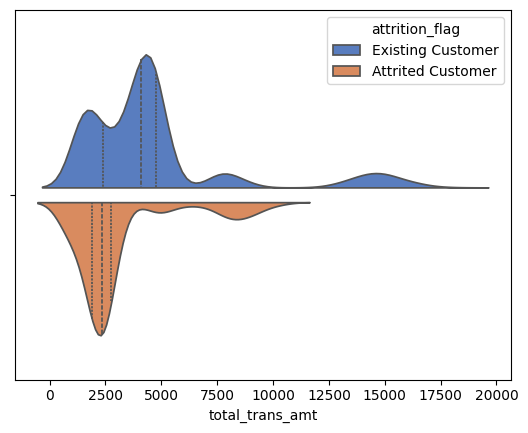

In [ ]:
show_relationship_numeric_category(
    df['total_trans_amt'],
    df['attrition_flag'],
)

total_trans_ct vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.37


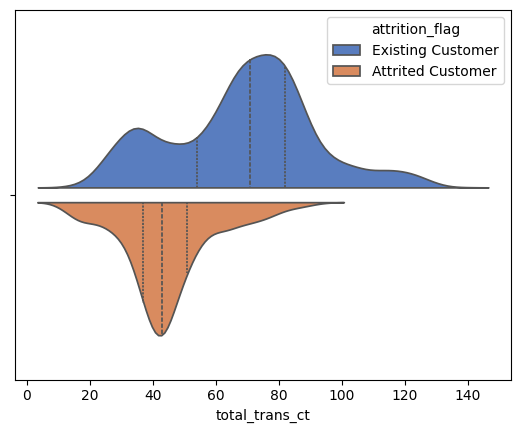

In [ ]:
show_relationship_numeric_category(
    df['total_trans_ct'],
    df['attrition_flag'],
)

total_ct_chng_q4_q1 vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.29


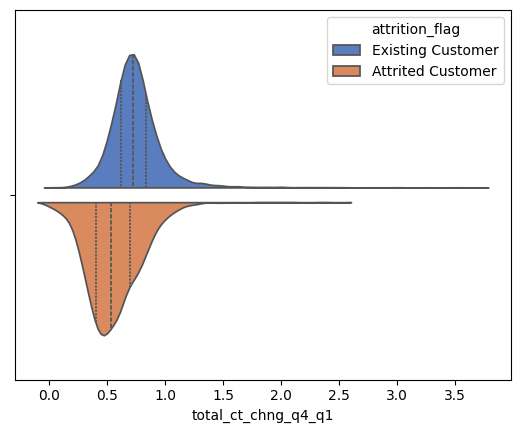

In [ ]:
show_relationship_numeric_category(
    df['total_ct_chng_q4_q1'],
    df['attrition_flag'],
)

avg_utilization_ratio vs attrition_flag
Point Biserial p-Value     : 0.0
Point Biserial Coefficient : 0.18


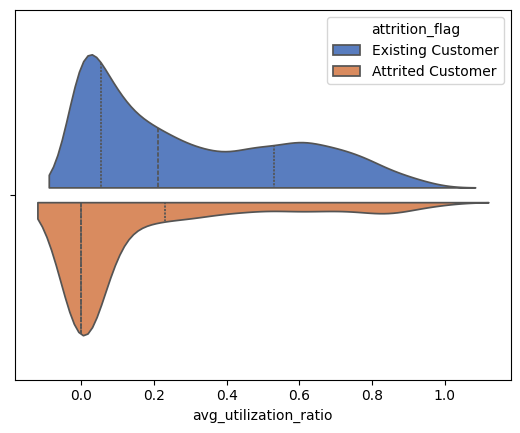

In [ ]:
show_relationship_numeric_category(
    df['avg_utilization_ratio'],
    df['attrition_flag'],
)

##Bivariate

###Category vs Category

Asterisk (*) indicates significant relationship between the two
variables based on Chi2 Test (p-value < 0.05). The number shown in each
cell is the relationship strength coefficient based on Cramer's V.



<Axes: xlabel='column2', ylabel='column1'>

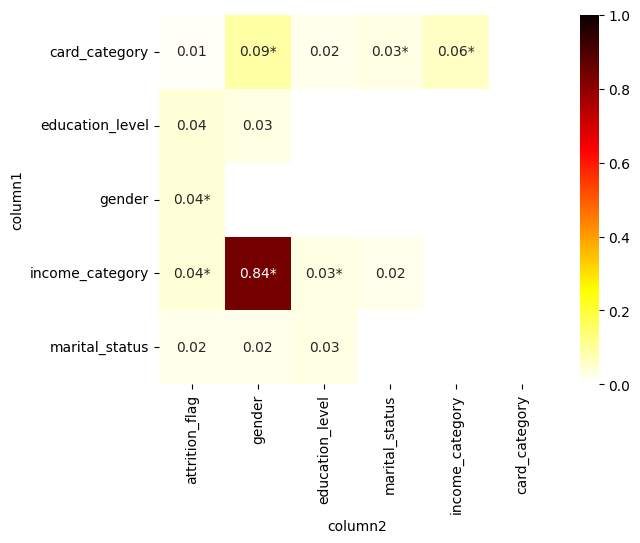

In [ ]:
corrs = [
  [], # column name 1
  [], # column name 2
  [], # p value
  [], # association strenght coefficient
]
for i in range(len(categorical_cols)):
  for j in range(i+1, len(categorical_cols)):
    pvalue, coef = show_relationship_category_category(
      df[categorical_cols[i]],
      df[categorical_cols[j]],
      return_result=True,
    )

    corrs[0].extend([categorical_cols[i], categorical_cols[j]])
    corrs[1].extend([categorical_cols[j], categorical_cols[i]])

    if i > j:
      corrs[2].extend([pvalue, None])
      corrs[3].extend([coef, None])
    else:
      corrs[2].extend([None, pvalue])
      corrs[3].extend([None, coef])

for i in range(len(categorical_cols)):
  pvalue, coef = show_relationship_category_category(
    df[categorical_cols[i]],
    df[target_column],
    return_result=True,
  )

  corrs[0].append(categorical_cols[i])
  corrs[1].append(target_column)
  corrs[2].append(pvalue)
  corrs[3].append(coef)

df_temp = pd.DataFrame({
  'column1': corrs[0],
  'column2': corrs[1],
  'pvalue': corrs[2],
  'coef': corrs[3],
})

df_temp['annot'] = np.where(
  df_temp['pvalue'].isnull(),
  None,
  np.where(
    df_temp['pvalue'] > 0.05,
    df_temp['coef'],
    df_temp['coef'].astype(str) + '*',
  ),
)

df_coef = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='coef',
  aggfunc='max',
)
df_coef = df_coef.reindex(columns = [target_column] + categorical_cols)

df_annot = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='annot',
  aggfunc='max',
)
df_annot = df_annot.reindex(columns = [target_column] + categorical_cols)

print('''Asterisk (*) indicates significant relationship between the two
variables based on Chi2 Test (p-value < 0.05). The number shown in each
cell is the relationship strength coefficient based on Cramer's V.
''')
sns.heatmap(
  df_coef,
  vmin = 0,
  vmax = 1,
  annot = df_annot,
  fmt = '',
  cmap = 'hot_r',
)

Asterisk (*) indicates significant relationship between the two
variables based on Chi2 Test (p-value < 0.05). The number shown in each
cell is the relationship strength coefficient based on Cramer's V.

Column inside the square bracket [] is the target variable.



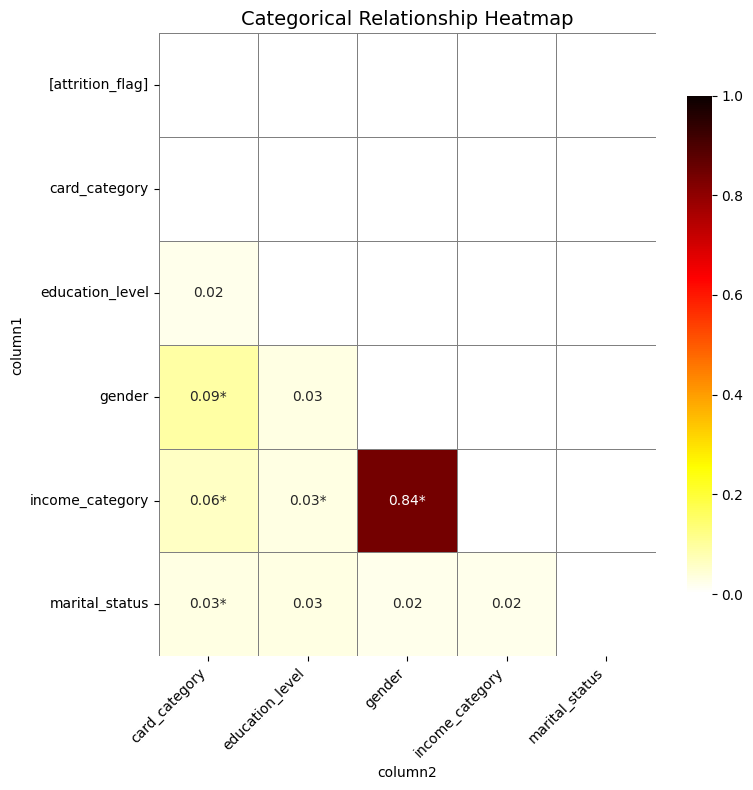

In [ ]:
corrs = [
  [], # column name 1
  [], # column name 2
  [], # p value
  [], # association strenght coefficient
]

for i in range(len(categorical_cols)):
  for j in range(i+1, len(categorical_cols)):
    pvalue, coef = show_relationship_category_category(
      df[categorical_cols[i]],
      df[categorical_cols[j]],
      return_result=True,
    )

    corrs[0].extend([categorical_cols[i], categorical_cols[j]])
    corrs[1].extend([categorical_cols[j], categorical_cols[i]])
    corrs[2].extend([pvalue, pvalue])
    corrs[3].extend([coef, coef])

for i in range(len(categorical_cols)):
  pvalue, coef = show_relationship_category_category(
    df[categorical_cols[i]],
    df[target_column],
    return_result=True,
  )

  corrs[0].append('[' + target_column + ']')
  corrs[1].append(categorical_cols[i])
  corrs[2].append(pvalue)
  corrs[3].append(coef)

df_temp = pd.DataFrame({
  'column1': corrs[0],
  'column2': corrs[1],
  'pvalue': corrs[2],
  'coef': corrs[3],
})

df_temp['annot'] = np.where(
  df_temp['pvalue'].isnull(),
  None,
  np.where(
    df_temp['pvalue'] > 0.05,
    df_temp['coef'],
    df_temp['coef'].astype(str) + '*',
  ),
)

df_coef = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='coef',
  aggfunc='max',
)


df_annot = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='annot',
  aggfunc='max',
)


mask = np.zeros_like(df_coef, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

print('''Asterisk (*) indicates significant relationship between the two
variables based on Chi2 Test (p-value < 0.05). The number shown in each
cell is the relationship strength coefficient based on Cramer's V.

Column inside the square bracket [] is the target variable.
''')
plt.figure(figsize=(8, 8))
sns.heatmap(
  df_coef,
  vmin = 0,
  vmax = 1,
  annot = df_annot,
  fmt = '',
  mask=mask,
  cmap = 'hot_r',
  linewidths=0.5,         # <- tambahkan garis antar sel
  linecolor='gray',       # <- warna garis
  cbar_kws={'shrink': 0.8} # <- perkecil colorbar
)
plt.xticks(rotation=45, ha='right')  # rotasi label X agar tidak tumpang tindih
plt.yticks(rotation=0)
plt.title("Categorical Relationship Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

###Numeric vs Category

Asterisk (*) indicates significant relationship (p-value < 0.05)
between the two variables based on:
- Point Biserial if number of distinct value in the category = 2;
- Chi2 Test if number of distinct value in the category > 2.

The number shown in each cell is the relationship strength coefficient
based on:
- Point Biserial if number of distinct value in the category = 2;
- Cramer's V if number of distinct value in the category > 2.



<Axes: xlabel='column2', ylabel='column1'>

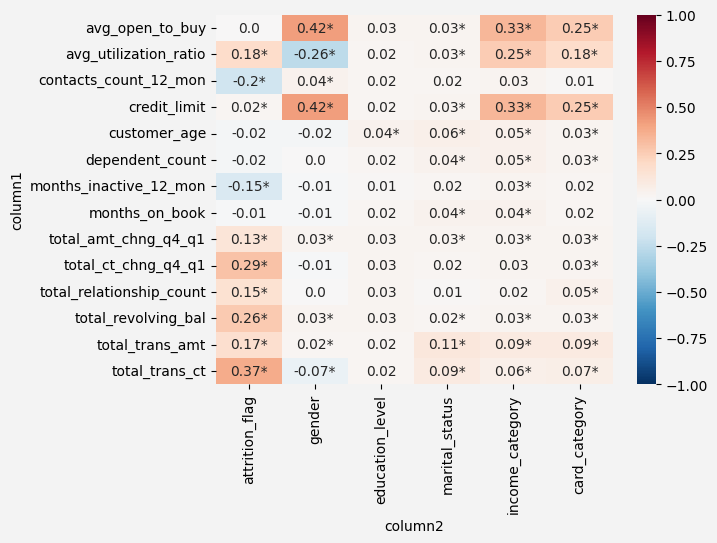

In [ ]:
corrs = [
  [], # column name 1
  [], # column name 2
  [], # p value
  [], # association strenght coefficient
]

for i in range(len(numerical_cols)):
  for j in range(len(categorical_cols)):
    pvalue, coef = show_relationship_numeric_category(
      df[numerical_cols[i]],
      df[categorical_cols[j]],
      return_result=True,
    )

    corrs[0].append(numerical_cols[i])
    corrs[1].append(categorical_cols[j])
    corrs[2].append(pvalue)
    corrs[3].append(coef)

for i in range(len(numerical_cols)):
  pvalue, coef = show_relationship_numeric_category(
    df[numerical_cols[i]],
    df[target_column],
    return_result=True,
  )

  corrs[0].append(numerical_cols[i])
  corrs[1].append(target_column)
  corrs[2].append(pvalue)
  corrs[3].append(coef)

df_temp = pd.DataFrame({
  'column1': corrs[0],
  'column2': corrs[1],
  'pvalue': corrs[2],
  'coef': corrs[3],
})

df_temp['annot'] = np.where(
  df_temp['pvalue'].isnull(),
  None,
  np.where(
    df_temp['pvalue'] > 0.05,
    df_temp['coef'],
    df_temp['coef'].astype(str) + '*',
  ),
)

df_coef = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='coef',
  aggfunc='max',
)
df_coef = df_coef.reindex(columns = [target_column] + categorical_cols)

df_annot = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='annot',
  aggfunc='max',
)
df_annot = df_annot.reindex(columns = [target_column] + categorical_cols)

print('''Asterisk (*) indicates significant relationship (p-value < 0.05)
between the two variables based on:
- Point Biserial if number of distinct value in the category = 2;
- Chi2 Test if number of distinct value in the category > 2.

The number shown in each cell is the relationship strength coefficient
based on:
- Point Biserial if number of distinct value in the category = 2;
- Cramer's V if number of distinct value in the category > 2.
''')
sns.set_style({
  'axes.facecolor': '#f3f3f3ff',
  'figure.facecolor': '#f3f3f3ff',
})
sns.heatmap(
  df_coef,
  vmin = -1,
  vmax = 1,
  annot = df_annot,
  fmt = '',
  cmap = 'RdBu_r',
)

In [ ]:
df_corr = df[numerical_cols].corr(method='spearman')
df_corr

customer_age  dependent_count  months_on_book  \
customer_age                  1.000000        -0.143583        0.768901   
dependent_count              -0.143583         1.000000       -0.114845   
months_on_book                0.768901        -0.114845        1.000000   
total_relationship_count     -0.014495        -0.035726       -0.013973   
months_inactive_12_mon        0.044389        -0.009174        0.057372   
contacts_count_12_mon        -0.014399        -0.041310       -0.008290   
credit_limit                  0.002435         0.050696        0.006870   
total_revolving_bal           0.013551        -0.003574        0.006289   
avg_open_to_buy              -0.002146         0.054437        0.007743   
total_amt_chng_q4_q1         -0.070538        -0.026267       -0.054364   
total_trans_amt              -0.038726         0.057847       -0.029127   
total_trans_ct               -0.053851         0.052897       -0.038772   
total_ct_chng_q4_q1          -0.040285         0.009414       -0.033842   
avg_utilization_ratio         0.010562        -0.034930       -0.003644   

                          total_relationship_count  months_inactive_12_mon  \
customer_age                             -0.014495                0.044389   
dependent_count                          -0.035726               -0.009174   
months_on_book                           -0.013973                0.057372   
total_relationship_count                  1.000000               -0.006644   
months_inactive_12_mon                   -0.006644                1.000000   
contacts_count_12_mon                     0.060954                0.030331   
credit_limit                             -0.059279               -0.027575   
total_revolving_bal                       0.011651               -0.042544   
avg_open_to_buy                          -0.070822               -0.015668   
total_amt_chng_q4_q1                      0.025689               -0.018774   
total_trans_amt                          -0.279113               -0.031945   
total_trans_ct                           -0.226808               -0.050852   
total_ct_chng_q4_q1                       0.024238               -0.046538   
avg_utilization_ratio                     0.065487               -0.026559   

                          contacts_count_12_mon  credit_limit  \
customer_age                          -0.014399      0.002435   
dependent_count                       -0.041310      0.050696   
months_on_book                        -0.008290      0.006870   
total_relationship_count               0.060954     -0.059279   
months_inactive_12_mon                 0.030331     -0.027575   
contacts_count_12_mon                  1.000000      0.022717   
credit_limit                           0.022717      1.000000   
total_revolving_bal                   -0.044788      0.131125   
avg_open_to_buy                        0.033265      0.931431   
total_amt_chng_q4_q1                  -0.020886      0.021289   
total_trans_amt                       -0.167372      0.028407   
total_trans_ct                        -0.168413      0.034222   
total_ct_chng_q4_q1                   -0.093311     -0.011409   
avg_utilization_ratio                 -0.058715     -0.416959   

                          total_revolving_bal  avg_open_to_buy  \
customer_age                         0.013551        -0.002146   
dependent_count                     -0.003574         0.054437   
months_on_book                       0.006289         0.007743   
total_relationship_count             0.011651        -0.070822   
months_inactive_12_mon              -0.042544        -0.015668   
contacts_count_12_mon               -0.044788         0.033265   
credit_limit                         0.131125         0.931431   
total_revolving_bal                  1.000000        -0.154165   
avg_open_to_buy                     -0.154165         1.000000   
total_amt_chng_q4_q1                 0.036129         0.007040   
total_trans_amt            

###Numeric vs Numeric

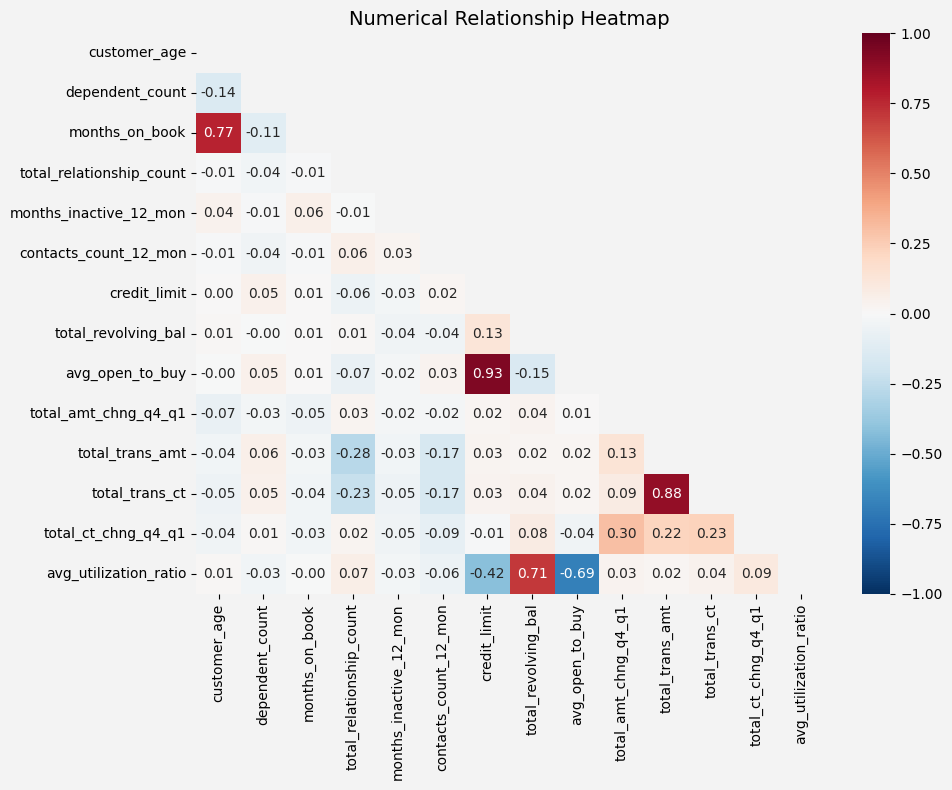

In [ ]:
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(
  df_corr,
  vmin = -1,
  vmax = 1,
  annot = True,
  mask = mask,
  fmt = '.2f',
  cmap = 'RdBu_r',
)
#plt.xticks(rotation=45, ha='right')  rotasi label X agar tidak tumpang tindih
plt.yticks(rotation=0)
plt.title("Numerical Relationship Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

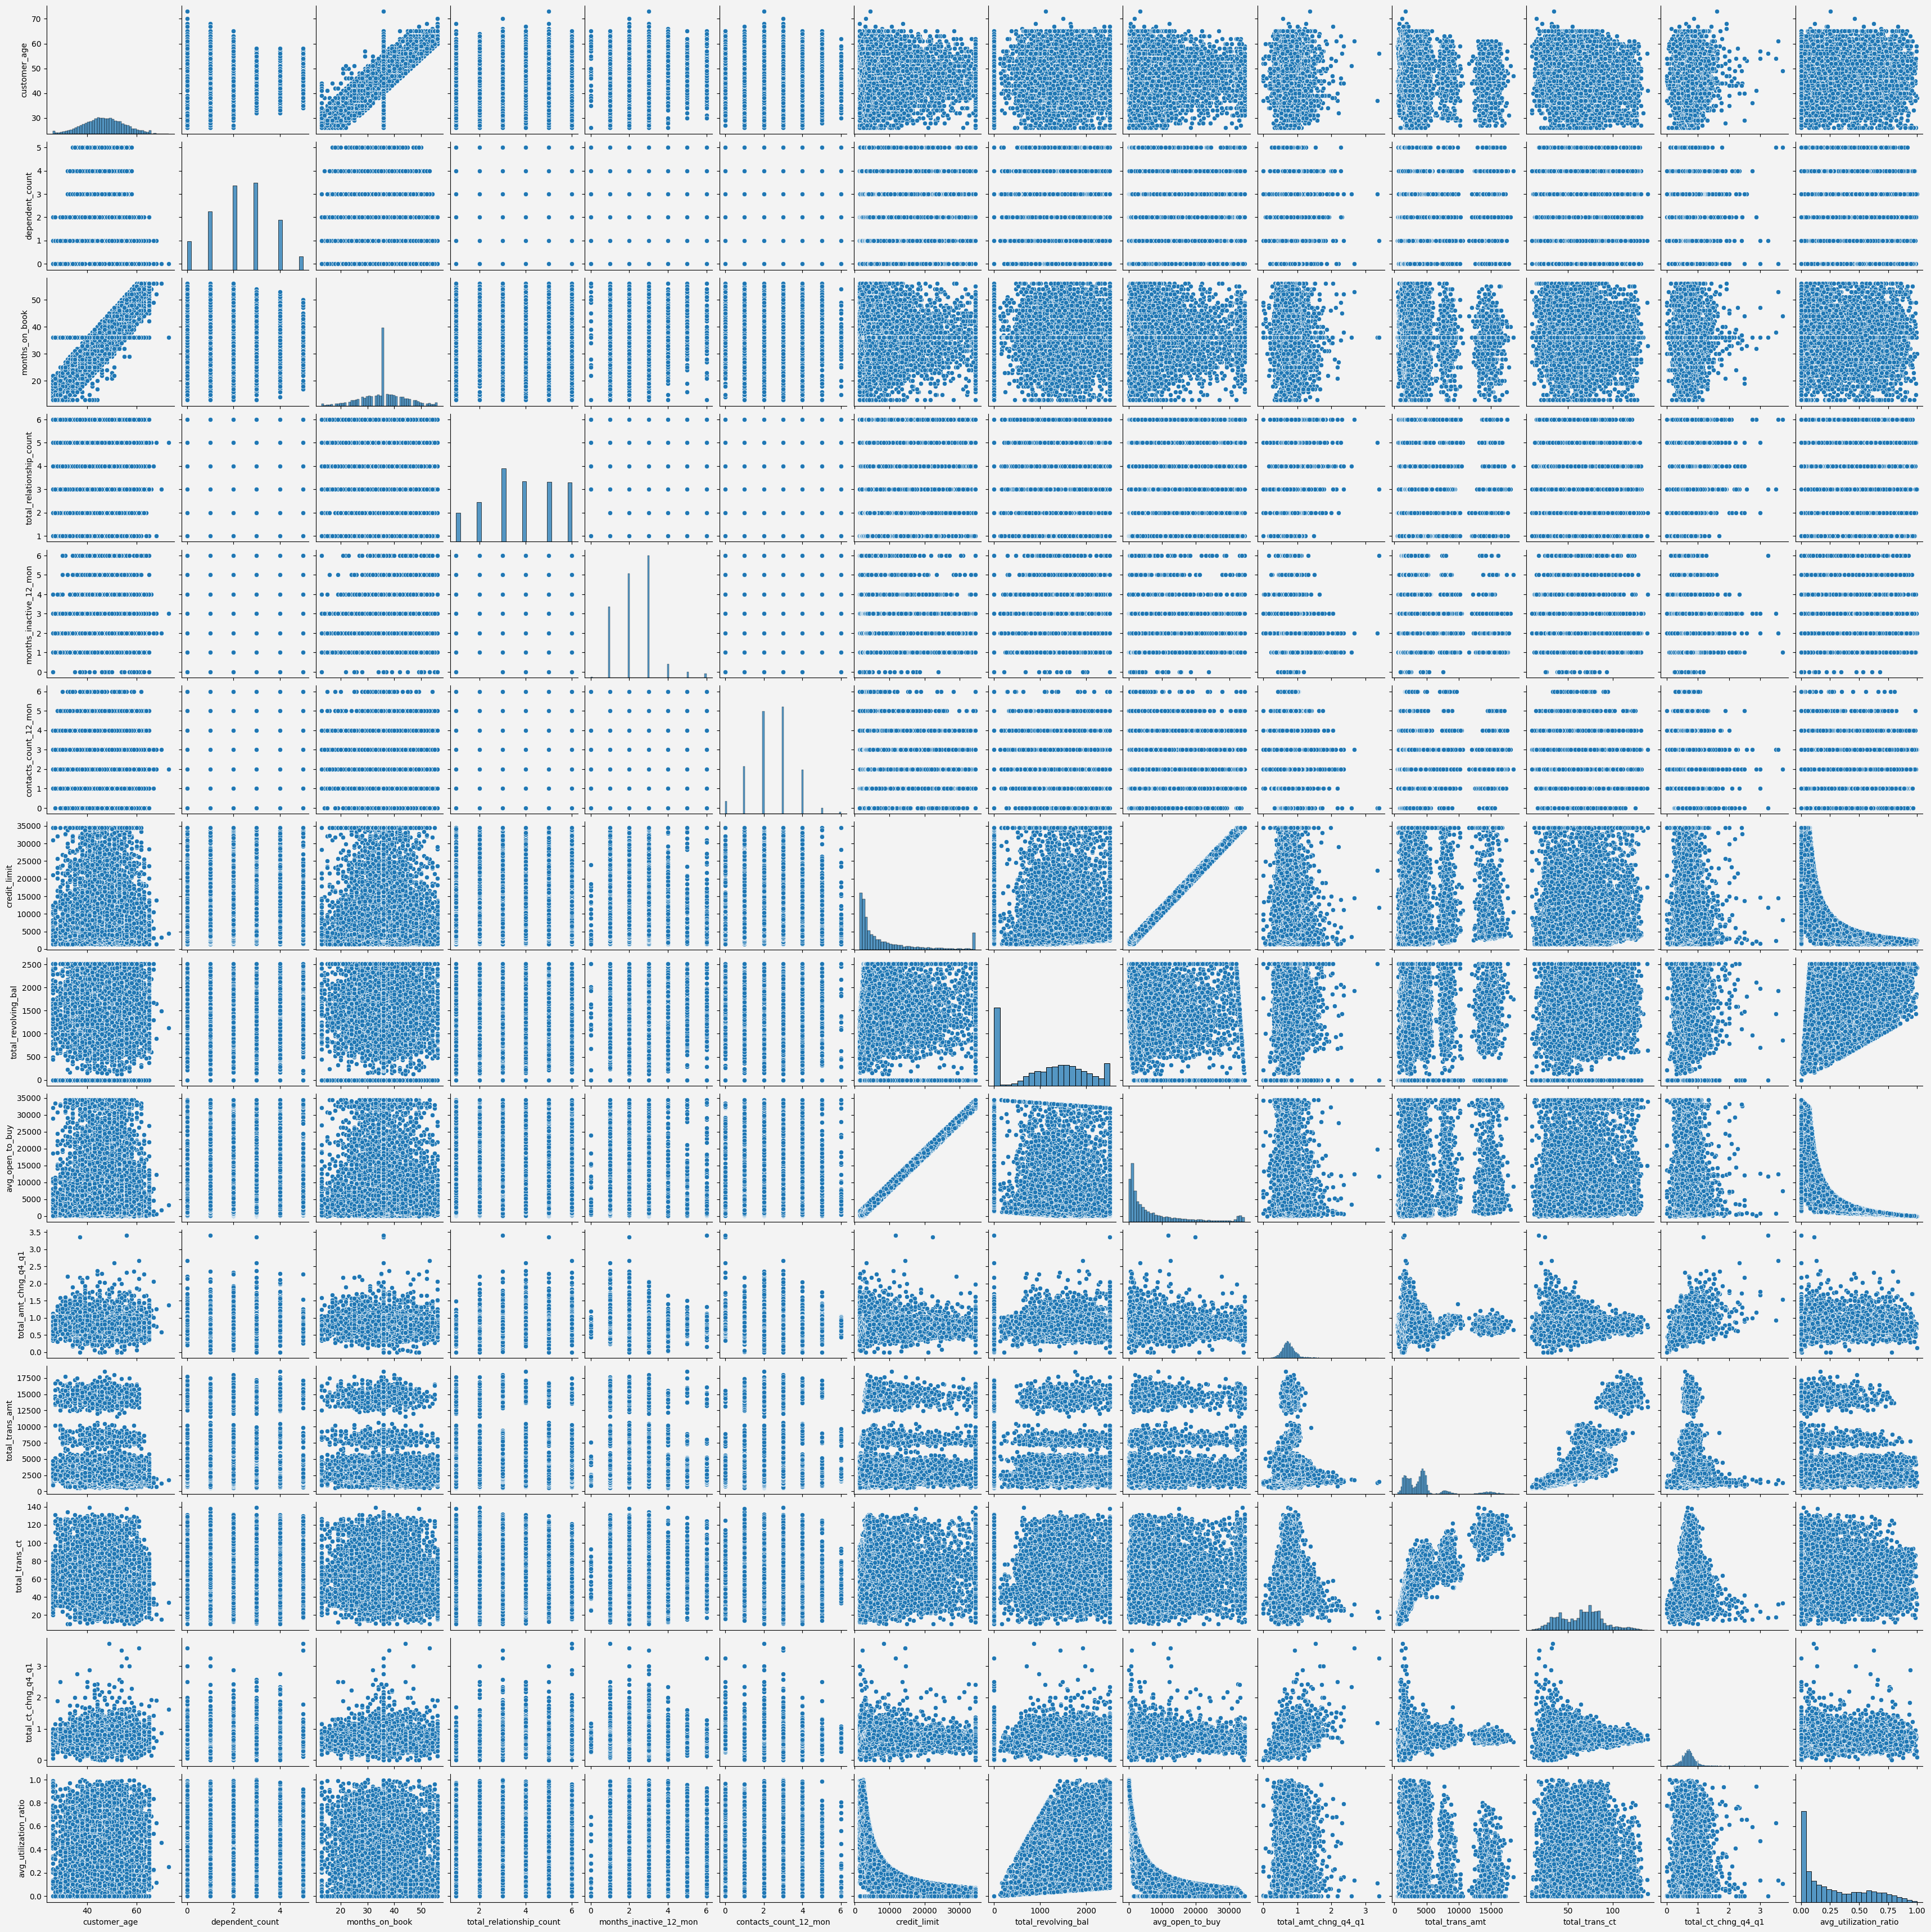

In [ ]:
sns.pairplot(df[numerical_cols])

In [ ]:
df.head()

user_id     attrition_flag  customer_age gender  dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  education_level marital_status income_category card_category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0              39                         5                       1   
1              44                         6                       1   
2              36                         4                       1   
3              34                         3                       4   
4              21                         5                       1   

   contacts_count_12_mon  credit_limit  total_revolving_bal  avg_open_to_buy  \
0                      3       12691.0                  777          11914.0   
1                      2        8256.0                  864           7392.0   
2                      0        3418.0                    0           3418.0   
3                      1        3313.0                 2517            796.0   
4                      0        4716.0                    0           4716.0   

   total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   avg_utilization_ratio  churn age_group tenure_bin contacts_bin  
0                  0.061      0     40-49   [36, 48)       (2, 3]  
1                  0.105      0     40-49   [36, 48)       (1, 2]  
2                  0.000      0     50-59   [36, 48)      (-1, 0]  
3                  0.760      0     40-49   [24, 36)       (0, 1]  
4                  0.000      0     40-49   [12, 24)      (-1, 0]

#Preprocess data

##Train Test Split

In [ ]:
df_n = df.copy()
df_n = df_n.drop(columns=['user_id', 'avg_open_to_buy', 'attrition_flag','age_group','tenure_bin','contacts_bin'])

X_train, X_test, y_train, y_test = train_test_split(
  df_n.drop(columns=target_column),
  df_n[target_column],
  test_size = 0.2,
  random_state = 11,
  stratify = df_n[target_column],
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8101, 18), (2026, 18), (8101,), (2026,))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 6177 to 8622
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              8101 non-null   int64  
 1   gender                    8101 non-null   object 
 2   dependent_count           8101 non-null   int64  
 3   education_level           8101 non-null   object 
 4   marital_status            8101 non-null   object 
 5   income_category           8101 non-null   object 
 6   card_category             8101 non-null   object 
 7   months_on_book            8101 non-null   int64  
 8   total_relationship_count  8101 non-null   int64  
 9   months_inactive_12_mon    8101 non-null   int64  
 10  contacts_count_12_mon     8101 non-null   int64  
 11  credit_limit              8101 non-null   float64
 12  total_revolving_bal       8101 non-null   int64  
 13  total_amt_chng_q4_q1      8101 non-null   float64
 14  total_tran

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 5251 to 9888
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              2026 non-null   int64  
 1   gender                    2026 non-null   object 
 2   dependent_count           2026 non-null   int64  
 3   education_level           2026 non-null   object 
 4   marital_status            2026 non-null   object 
 5   income_category           2026 non-null   object 
 6   card_category             2026 non-null   object 
 7   months_on_book            2026 non-null   int64  
 8   total_relationship_count  2026 non-null   int64  
 9   months_inactive_12_mon    2026 non-null   int64  
 10  contacts_count_12_mon     2026 non-null   int64  
 11  credit_limit              2026 non-null   float64
 12  total_revolving_bal       2026 non-null   int64  
 13  total_amt_chng_q4_q1      2026 non-null   float64
 14  total_tran

##Encode

In [ ]:
# Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Pastikan ambil semua kolom kategorikal
ohe.fit(X_train[categorical_cols])

X_train_encoded = ohe.transform(X_train[categorical_cols])
X_test_encoded = ohe.transform(X_test[categorical_cols])

# Ambil nama kolom baru hasil OHE
ohe_cols = ohe.get_feature_names_out(categorical_cols)

# Bungkus ke DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe_cols, index=X_test.index)

# Gabungkan kembali dengan fitur numerikal
X_train_final = pd.concat(
    [X_train.drop(columns=categorical_cols), X_train_encoded_df], axis=1
)
X_test_final = pd.concat(
    [X_test.drop(columns=categorical_cols), X_test_encoded_df], axis=1
)

In [ ]:
#Tentukan kolom numerik
numerical_cols = [
    col for col in X_train.columns
    if X_train[col].dtype in ['int64', 'float64'] # Correctly identify numerical columns
]

#Buat scaler
scaler = RobustScaler()

# Copy dulu supaya X_train_final tetap utuh
X_train_scaled = X_train_final.copy()
X_test_scaled = X_test_final.copy()

# Fit di train, transform di train & test
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_final[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test_final[numerical_cols])

# Cek hasil
X_train_scaled.head()

customer_age  dependent_count  months_on_book  total_relationship_count  \
6177     -0.636364              0.0       -0.333333                      -0.5   
4062     -0.090909              0.5       -0.111111                       1.0   
2660      0.181818              0.0       -0.777778                       1.0   
2835     -0.909091             -0.5       -1.444444                       0.0   
8183     -1.818182             -1.0       -2.555556                      -1.0   

      months_inactive_12_mon  contacts_count_12_mon  credit_limit  \
6177                    -1.0                    1.0     -0.151494   
4062                     1.0                    0.0      0.059412   
2660                     0.0                    1.0      2.312754   
2835                     1.0                   -1.0     -0.362249   
8183                    -1.0                   -1.0      0.662714   

      total_revolving_bal  total_amt_chng_q4_q1  total_trans_amt  \
6177             0.476912             -0.219298         0.150251   
4062             0.062049             -0.241228        -0.131325   
2660             0.417027              0.206140         0.000772   
2835            -0.251082              0.508772        -0.660100   
8183            -0.920635             -0.986842         0.140209   

      total_trans_ct  total_ct_chng_q4_q1  avg_utilization_ratio  gender_F  \
6177        0.500000             0.445378               0.873444       1.0   
4062        0.222222            -0.974790               0.195021       0.0   
2660        0.222222             0.348739              -0.205394       0.0   
2835       -0.222222            -0.071429               0.975104       0.0   
8183        0.027778             0.567227              -0.363071       0.0   

      gender_M  education_level_College  education_level_Doctorate  \
6177       0.0                      0.0                        0.0   
4062       1.0                      0.0                        0.0   
2660       1.0                      0.0                        0.0   
2835       1.0                      0.0                        0.0   
8183       1.0                      0.0                        0.0   

      education_level_Graduate  education_level_High School  \
6177                       0.0                          0.0   
4062                       1.0                          0.0   
2660                       1.0                          0.0   
2835                       0.0                          0.0   
8183                       0.0                          0.0   

      education_level_Post-Graduate  education_level_Uneducated  \
6177                            0.0                         0.0   
4062                            0.0                         0.0   
2660                            0.0                         0.0   
2835                            0.0                         0.0   
8183                            0.0                         0.0   

      education_level_Unknown  marital_status_Divorced  \
6177                      1.0                      0.0   
4062                      0.0                      1.0   
2660                      0.0                      1.0   
2835                      1.0                      0.0   
8183                      1.0                      0.0   

      marital_status_Married  marital_status_Single  marital_status_Unknown  \
6177                     1.0                    0.0                     0.0   
4062                     0.0                    0.0                     0.0   
2660                     0.0                    0.0                     0.0   
2835                     0.0                    1.0                     0.0   
8183                     0.0                    0.0                     1.0   

      income_category_$120K +  income_category_$40K - $60K  \
6177                      0.0                          0.0   
4062                      0.0                          0.0   
2660         

##Imbalance data (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Fit & resample hanya di data training
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.shape,
      "Positif:", sum(y_train),
      "Negatif:", len(y_train) - sum(y_train))
print("After SMOTE:", y_train_res.shape,
      "Positif:", sum(y_train_res),
      "Negatif:", len(y_train_res) - sum(y_train_res))

Before SMOTE: (8101,) Positif: 1302 Negatif: 6799
After SMOTE: (13598,) Positif: 6799 Negatif: 6799


#Select Model

##Logistic Regression

###Train

In [ ]:
model = LogisticRegression(
  penalty = 'l2',
  C = 1.0,
  random_state = 11,
  solver = 'lbfgs',
)

model.fit(X_train_res, y_train_res)

scores = cross_val_score(
  model,
  X_train_res,
  y_train_res,
  cv = 5,
  scoring = 'f1',
)

Mean : 0.865
STD : 0.006


<Axes: >

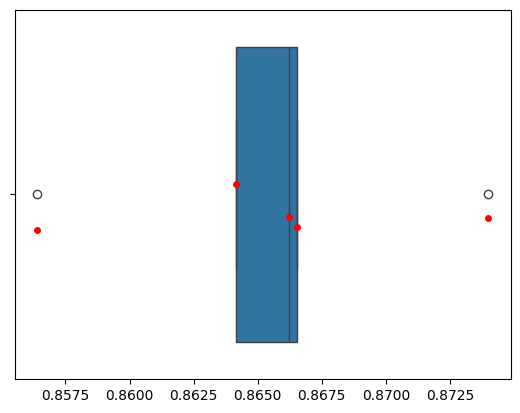

In [ ]:
print('Mean :', round(scores.mean(), 3))
print('STD :', round(scores.std(), 3))

sns.boxplot(x=scores, orient='h')
sns.stripplot(x=scores, color='red')

###Evaluation

In [ ]:
y_train_pred = model.predict(X_train_res)
print(classification_report(y_train_res, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6799
           1       0.86      0.87      0.87      6799

    accuracy                           0.87     13598
   macro avg       0.87      0.87      0.87     13598
weighted avg       0.87      0.87      0.87     13598



In [ ]:
y_test_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1701
           1       0.53      0.82      0.64       325

    accuracy                           0.85      2026
   macro avg       0.75      0.84      0.78      2026
weighted avg       0.89      0.85      0.87      2026



Classification Report -> recall cukup tinggi (0.82) tapi precision rendah (0.53) → banyak false positive.

###Interpretation

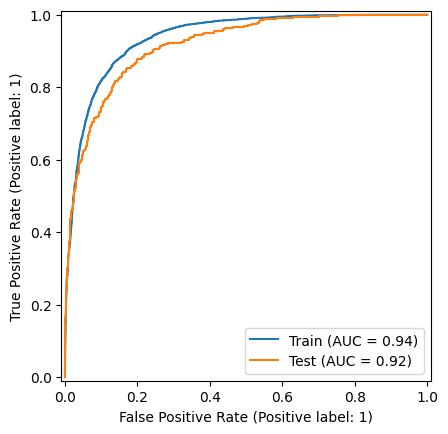

In [ ]:
auc_train = RocCurveDisplay.from_estimator(
  model,
  X_train_res,
  y_train_res,
  name='Train',
)

RocCurveDisplay.from_estimator(
  model,
  X_test_scaled,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

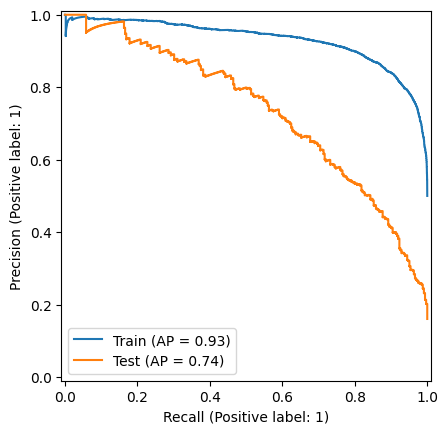

In [ ]:
auc_train = PrecisionRecallDisplay.from_estimator(
  model,
  X_train_res,
  y_train_res,
  name='Train',
)

PrecisionRecallDisplay.from_estimator(
  model,
  X_test_scaled,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

In [ ]:
df_feature = pd.DataFrame({
  'feature': X_train_res.columns,
  'coef': model.coef_[0],
  'coef_abs': abs(model.coef_[0]),
})

df_feature.sort_values('coef_abs', ascending=False)

feature      coef  coef_abs
10                  total_trans_ct -5.021098  5.021098
9                  total_trans_amt  1.520464  1.520464
7              total_revolving_bal -1.308436  1.308436
14                        gender_M -0.968869  0.968869
3         total_relationship_count -0.830654  0.830654
11             total_ct_chng_q4_q1 -0.794699  0.794699
31         income_category_Unknown -0.692475  0.692475
4           months_inactive_12_mon  0.598536  0.598536
5            contacts_count_12_mon  0.580416  0.580416
23          marital_status_Married -0.566659  0.566659
34          card_category_Platinum -0.464525  0.464525
15         education_level_College -0.451369  0.451369
32              card_category_Blue -0.440260  0.440260
35            card_category_Silver -0.427303  0.427303
33              card_category_Gold  0.381922  0.381922
27     income_category_$40K - $60K -0.381887  0.381887
29    income_category_$80K - $120K  0.362309  0.362309
1                  dependent_count  0.340632  0.340632
17        education_level_Graduate -0.283820  0.283820
25          marital_status_Unknown -0.283038  0.283038
26         income_category_$120K +  0.274983  0.274983
16       education_level_Doctorate  0.264574  0.264574
30  income_category_Less than $40K -0.263892  0.263892
28     income_category_$60K - $80K -0.249204  0.249204
18     education_level_High School -0.227454  0.227454
20      education_level_Uneducated -0.220443  0.220443
22         marital_status_Divorced -0.145189  0.145189
2                   months_on_book -0.104539  0.104539
8             total_amt_chng_q4_q1 -0.096982  0.096982
21         education_level_Unknown -0.066423  0.066423
6                     credit_limit -0.055176  0.055176
24           marital_status_Single  0.044720  0.044720
19   education_level_Post-Graduate  0.034770  0.034770
0                     customer_age -0.032630  0.032630
13                        gender_F  0.018703  0.018703
12           avg_utilization_ratio -0.002869  0.002869

Train AUC = 0.94, Test AUC = 0.92

Model cukup baik membedakan churn vs tidak churn, tapi gap antara train dan test menunjukkan sedikit penurunan generalisasi

Train AP = 0.93, Test AP = 0.74

Penurunan cukup signifikan di test, artinya model kehilangan presisi saat recall tinggi di data baru



##XGBoost

###Train

In [ ]:
space = {
  'learning_rate': uniform(loc=0.3, scale=0.7),
  'gamma': uniform(loc=1, scale=8),
  'max_depth': randint(3, 12),
  'reg_lambda' : uniform(loc=0, scale=1),
  'reg_alpha' : randint(0, 180),
  'colsample_bytree' : uniform(loc=0.5, scale=0.5),
  'min_child_weight' : randint(0, 10),
  'n_estimators': [100, 140, 180],
}

In [ ]:
model = xgb.XGBClassifier(
  scale_pos_weight = (y_train_res.shape[0] - sum(y_train_res)) / sum(y_train_res),
)

hp = RandomizedSearchCV(
  model,
  space,
  n_iter = 10,
  scoring = 'f1',
  return_train_score = True,
  random_state = 11,
)

search = hp.fit(X_train_res, y_train_res)

In [ ]:
pd.DataFrame.from_dict(search.cv_results_).sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.495324      0.321198         0.010735        0.000498   
6       0.787054      1.014652         0.013981        0.004047   
3       0.302385      0.011015         0.013375        0.005565   
8       0.350970      0.021029         0.010522        0.000142   
2       0.337179      0.014225         0.011062        0.001533   
7       0.287107      0.056564         0.010017        0.000081   
4       0.263319      0.012510         0.012361        0.005052   
1       0.202932      0.013038         0.009618        0.000058   
9       0.292165      0.018644         0.010242        0.000192   
5       0.203239      0.011134         0.009955        0.000714   

   param_colsample_bytree  param_gamma  param_learning_rate  param_max_depth  \
0                0.590135     1.155802             0.624253                4   
6                0.531843     3.916925             0.349016                4   
3                0.512575     8.370230             0.587639                9   
8                0.718120     6.862603             0.344021               11   
2                0.928577     2.320693             0.742634               11   
7                0.838765     8.906054             0.628749                4   
4                0.887415     4.864850             0.848316                3   
1                0.743686     8.534453             0.895557                7   
9                0.667370     5.014181             0.804396                4   
5                0.776192     8.592819             0.990671                4   

   param_min_child_weight  param_n_estimators  param_reg_alpha  \
0                       7                 180               24   
6                       2                 140               48   
3                       9                 180               27   
8                       6                 180              119   
2                       1                 180              171   
7                       1                 140              124   
4                       8                 140               71   
1                       2                 100              129   
9                       5                 180              148   
5                       4                 100              114   

   param_reg_lambda                                             params  \
0          0.012781  {'colsample_bytree': 0.5901348444383846, 'gamm...   
6          0.923850  {'colsample_bytree': 0.5318432153873277, 'gamm...   
3          0.155145  {'colsample_bytree': 0.5125746382734908, 'gamm...   
8          0.951108  {'colsample_bytree': 0.7181204668325805, 'gamm...   
2          0.778103  {'colsample_bytree': 0.9285771235364149, 'gamm...   
7          0.168817  {'colsample_bytree': 0.8387653973154735, 'gamm...   
4          0.602064  {'colsample_bytree': 0.8874153070134796, 'gamm...   
1          0.893904  {'colsample_bytree': 0.7436858036599359, 'gamm...   
9          0.810967  {'colsample_bytree': 0.6673701701048933, 'gamm...   
5          0.796436  {'colsample_bytree': 0.7761919107527486, 'gamm...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.896083           0.973761           0.972132           0.968375   
6           0.914198           0.961314           0.960870           0.955733   
3           0.895534           0.963636           0.967368           0.955957   
8           0.917044           0.946632           0.948895           0.946260   
2           0.915781           0.938262           0.950820           0.940962   
7           0.911153           0.937820           0.941730           0.934491   
4           0.899694           0.936672           0.937068           0.941305   
1           0.899272           0.938580           0.936357           0.938998   
9           0.908063           0.934456           0.937683           0.933140   
5           0.898318           0

In [ ]:
search.best_score_

np.float64(0.9576874275831345)

In [ ]:
search.best_params_

{'colsample_bytree': np.float64(0.5901348444383846),
 'gamma': np.float64(1.1558019319009967),
 'learning_rate': np.float64(0.6242529685488412),
 'max_depth': 4,
 'min_child_weight': 7,
 'n_estimators': 180,
 'reg_alpha': 24,
 'reg_lambda': np.float64(0.012780814590608647)}

In [ ]:
model = search.best_estimator_
model.fit(X_train_res, y_train_res)
scores = cross_val_score(
  model,
  X_train_res,
  y_train_res,
  cv = 5,
  scoring = 'f1',
)

Mean : 0.958
STD : 0.031


<Axes: >

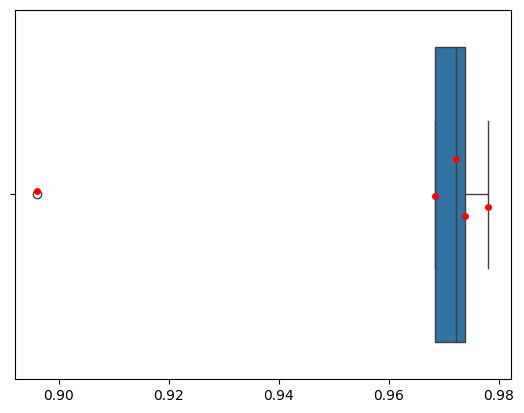

In [ ]:
print('Mean :', round(scores.mean(), 3))
print('STD :', round(scores.std(), 3))

sns.boxplot(x=scores, orient='h')
sns.stripplot(x=scores, color='red')

###Evaluation

In [ ]:
y_train_pred = model.predict(X_train_res)
print(classification_report(y_train_res, y_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6799
           1       0.97      0.98      0.97      6799

    accuracy                           0.97     13598
   macro avg       0.97      0.97      0.97     13598
weighted avg       0.97      0.97      0.97     13598



In [ ]:
y_test_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1701
           1       0.86      0.91      0.88       325

    accuracy                           0.96      2026
   macro avg       0.92      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026



precision tinggi (0.86) dan recall tinggi (0.91) → seimbang, jauh lebih baik

###Interpretation

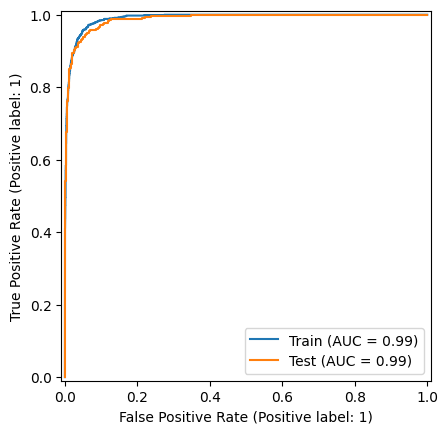

In [ ]:
auc_train = RocCurveDisplay.from_estimator(
  model,
  X_train_scaled,
  y_train,
  name='Train',
)

RocCurveDisplay.from_estimator(
  model,
  X_test_scaled,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

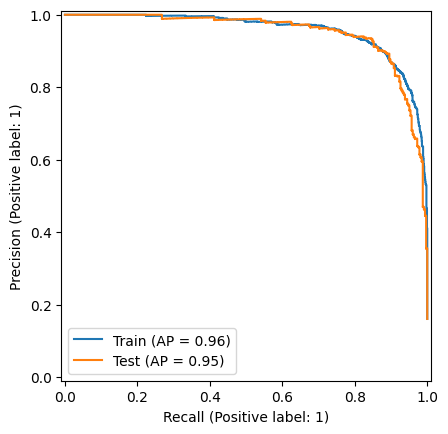

In [ ]:
auc_train = PrecisionRecallDisplay.from_estimator(
  model,
  X_train_scaled,
  y_train,
  name='Train',
)

PrecisionRecallDisplay.from_estimator(
  model,
  X_test_scaled,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

Train AUC = 0.99, Test AUC = 0.99

Hampir sempurna membedakan kelas di train dan test, dan tidak ada penurunan berarti → model generalisasi sangat baik

Train AP = 0.96, Test AP = 0.95

Stabil di train dan test → konsistensi prediksi sangat bagus

Kesimpulan & Model Terbaik:

XGBoost adalah model terbaik di sini, karena

Skor AUC, AP, Precision, Recall, F1 lebih tinggi di test set

Konsistensi train–test bagus (tidak overfitting signifikan)

Lebih akurat mengidentifikasi customer churn tanpa mengorbankan presisi

##Visualization

###Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

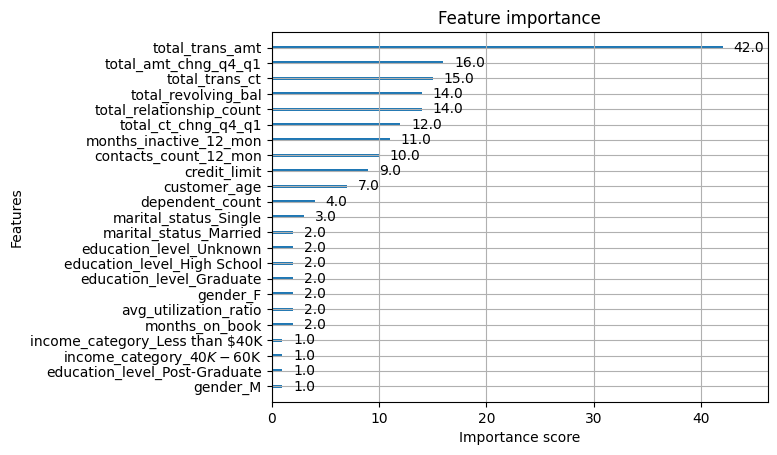

In [ ]:
xgb.plot_importance(model, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

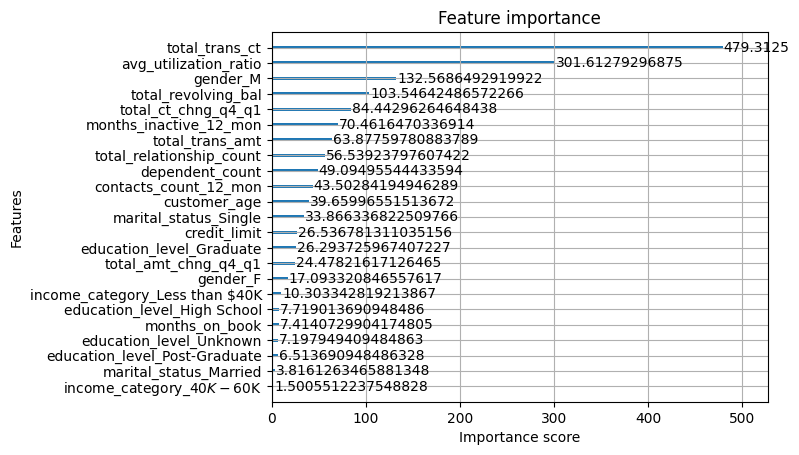

In [ ]:
xgb.plot_importance(model, importance_type='gain')

###Permutation Importance

feature  importance_mean  importance_std
10             total_trans_ct         0.468500        0.008244
9             total_trans_amt         0.200219        0.005388
3    total_relationship_count         0.061661        0.003622
7         total_revolving_bal         0.040382        0.004052
11        total_ct_chng_q4_q1         0.034868        0.003540
4      months_inactive_12_mon         0.019501        0.003247
8        total_amt_chng_q4_q1         0.017422        0.001559
0                customer_age         0.014926        0.001664
6                credit_limit         0.014554        0.002300
5       contacts_count_12_mon         0.004485        0.002003
12      avg_utilization_ratio         0.002972        0.002125
24      marital_status_Single         0.001530        0.001862
13                   gender_F         0.001383        0.001511
1             dependent_count         0.000965        0.001896
17   education_level_Graduate         0.000672        0.000682
23     marital_status_Married         0.000520        0.000692
2              months_on_book         0.000290        0.000374
21    education_level_Unknown         0.000100        0.000344
16  education_level_Doctorate         0.000000        0.000000
15    education_level_College         0.000000        0.000000

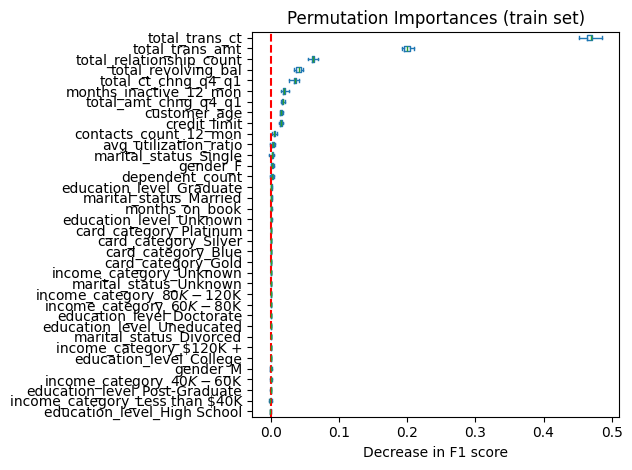

In [ ]:
result = permutation_importance(
  model,
  X_train_scaled,
  y_train,
  scoring='f1',
  n_repeats=10,
  random_state=11,
)

sorted_importances_idx = result.importances_mean.argsort()
df_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train_scaled.columns[sorted_importances_idx],
)
ax = df_importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances (train set)')
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel('Decrease in F1 score')
ax.figure.tight_layout()

df_importances = pd.DataFrame({'feature': X_train_scaled.columns, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std})
display(df_importances.sort_values('importance_mean', ascending=False).head(20))

###Shapley

In [ ]:
explainer = shap.TreeExplainer(
  model,
  X_train_scaled,
  feature_perturbation='interventional',
  model_output='probability',
)
explanation = explainer(X_train_scaled)
shap_values = explainer.shap_values(X_train_scaled)

 95%|=================== | 7703/8101 [00:11<00:00]       

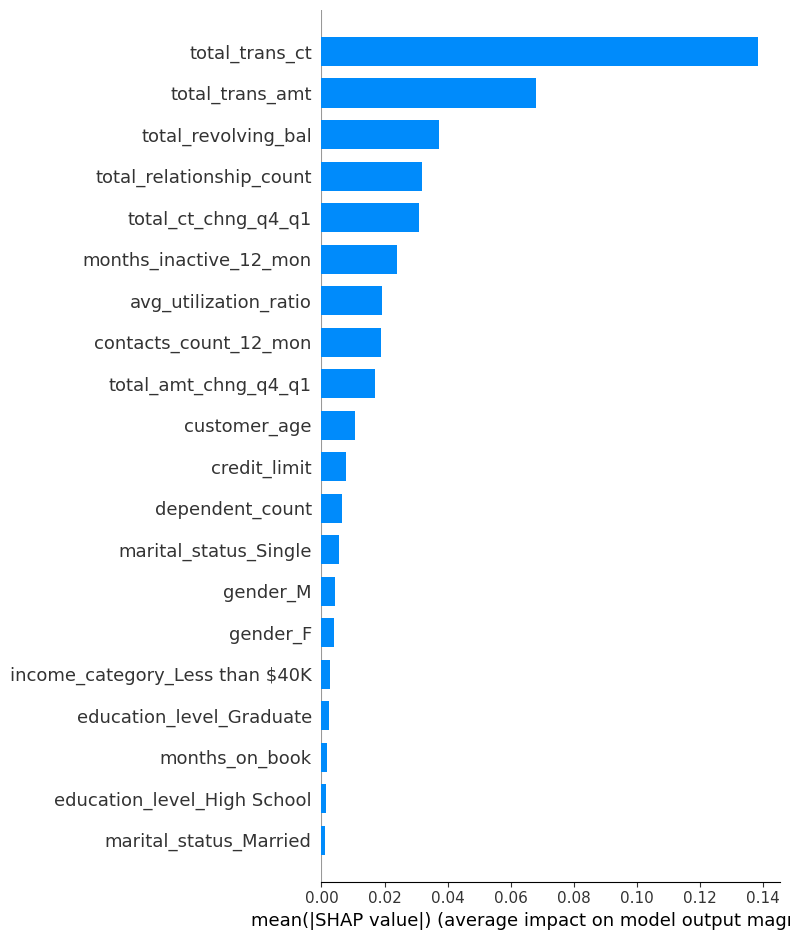

In [ ]:
shap.summary_plot(shap_values, X_train_scaled, plot_type='bar')

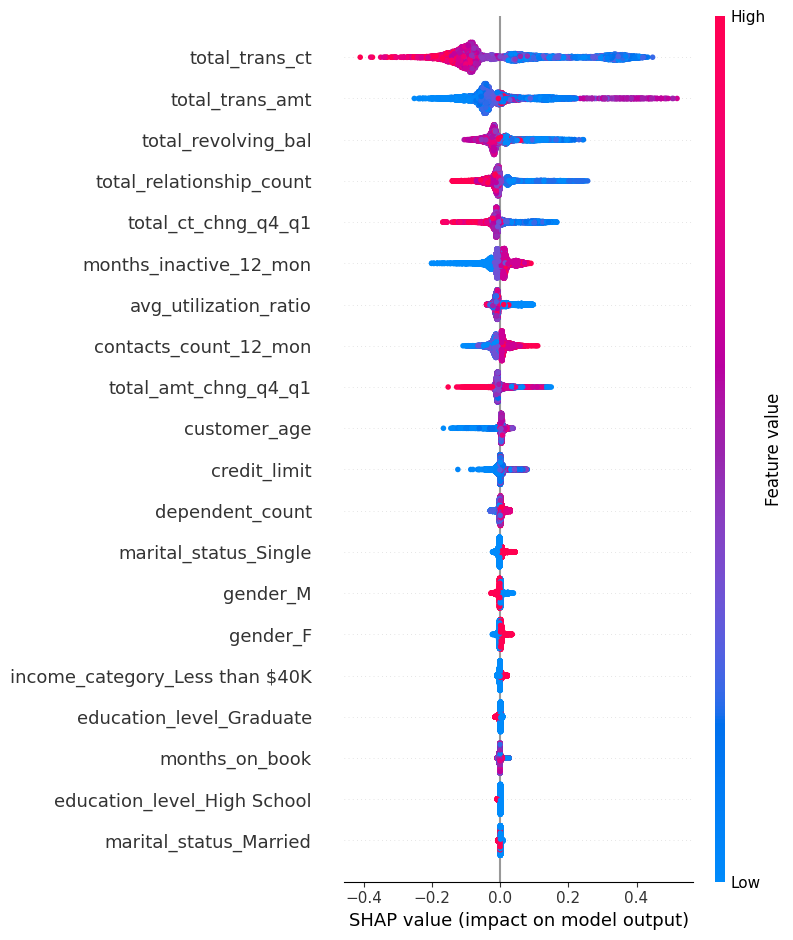

In [ ]:
shap.summary_plot(shap_values, X_train_scaled)

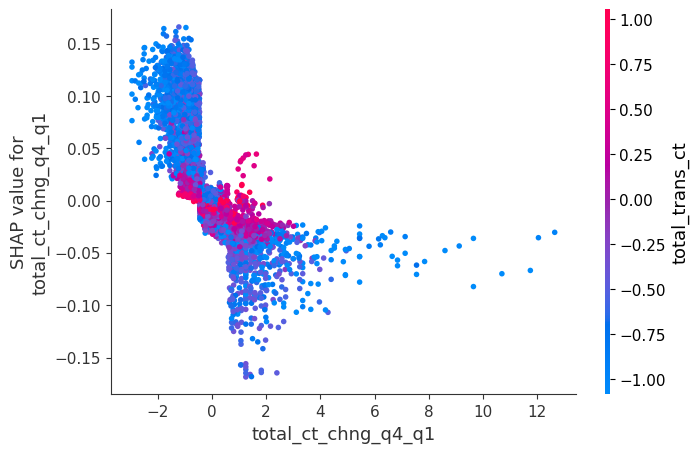

In [ ]:
shap.dependence_plot(
  'total_ct_chng_q4_q1',
  shap_values,
  X_train_scaled,
)

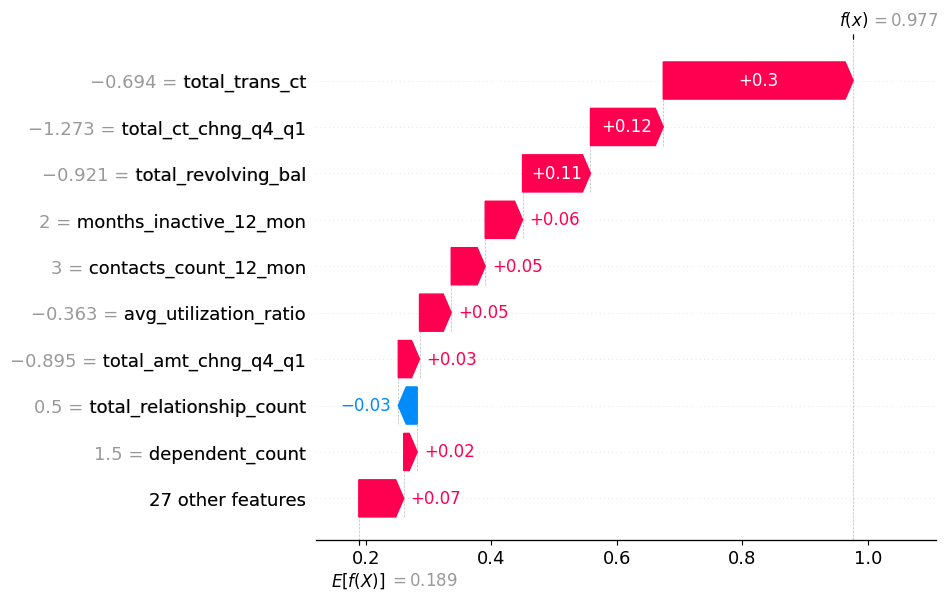

In [ ]:
shap.plots.waterfall(explanation[11])

Karena stakeholder anda membutuhkan knowledge dari model, analisislah
model yang anda buat dengan menggunakan explanatory model analysis dan
buatlah rekomendasi berdasarkan hasil dari analisis tersebut

Berdasarkan analisis feature importance dan SHAP:

1. total_trans_ct (jumlah transaksi dalam setahun)

  - Fitur paling berpengaruh terhadap churn
  - Nilai rendah → kemungkinan churn tinggi
  - Customer dengan aktivitas transaksi yang jarang cenderung tidak terikat dengan layanan dan berpotensi pindah ke kompetitor.

2. avg_utilization_ratio (rasio penggunaan kredit)
  - Nilai sangat rendah atau terlalu tinggi dapat memengaruhi churn
  - Nilai rendah → Customer jarang memanfaatkan kartu, indikasi rendahnya keterlibatan
  - Nilai tinggi → kemungkinan masalah kemampuan bayar, berpotensi churn karena kesulitan finansial

3. total_revolving_bal (saldo mengendap)
  - Saldo yang terlalu rendah bisa menunjukkan Customer tidak aktif menggunakan kartu
  - Saldo tinggi tapi disertai aktivitas rendah juga bisa jadi sinyal churn

4. months_inactive_12_mon
  Semakin banyak bulan tidak aktif, semakin tinggi risiko churn

5. contacts_count_12_mon
  Customer yang sering menghubungi customer service kadang memiliki masalah yang belum terselesaikan, meningkatkan risiko churn

Rekomendasi untuk Bisnis

1. Program Aktivasi untuk Customer Transaksi Rendah

  Berikan promo, cashback, atau diskon biaya tahunan untuk Customer dengan total_trans_ct rendah agar mereka kembali aktif.

2. Segmentasi Berdasarkan Utilisasi Kredit

  - Customer dengan avg_utilization_ratio sangat rendah → dorong penggunaan melalui penawaran limit tambahan atau cicilan bunga rendah

  - Customer dengan rasio sangat tinggi → tawarkan program restrukturisasi atau edukasi finansial untuk menghindari churn akibat kesulitan bayar

3. Monitoring Customer Inaktif

  Buat trigger sistem: jika months_inactive_12_mon > 6, langsung kirimkan penawaran atau survei kebutuhan

4. Tindak Lanjut Cepat dari Customer Service

  Customer dengan contacts_count_12_mon tinggi harus diprioritaskan dalam penyelesaian masalah

In [ ]:
top_summary = df_importances.sort_values('importance_mean', ascending=False).head(15)
display(top_summary)

recs = []
for f in top_summary['feature'].values:
    if 'total_trans_ct' in f or 'total_trans_amt' in f:
        recs.append("Pantau nasabah dengan jumlah/jumlah transaksi yang menurun; jalankan campaign retensi bagi mereka yang menunjukkan penurunan.")
    if 'avg_utilization_ratio' in f:
        recs.append("Rasio pemanfaatan yang tinggi menunjukkan risiko — prioritaskan pengingat pembayaran atau penawaran yang disesuaikan.")
    if 'months_on_book' in f:
        recs.append("Nasabah baru memiliki tingkat churn yang lebih tinggi — perkuat onboarding & keterlibatan awal.")
recs = list(dict.fromkeys(recs))
print("Recommendations:")
for r in recs:
    print("-", r)

feature  importance_mean  importance_std
10            total_trans_ct         0.468500        0.008244
9            total_trans_amt         0.200219        0.005388
3   total_relationship_count         0.061661        0.003622
7        total_revolving_bal         0.040382        0.004052
11       total_ct_chng_q4_q1         0.034868        0.003540
4     months_inactive_12_mon         0.019501        0.003247
8       total_amt_chng_q4_q1         0.017422        0.001559
0               customer_age         0.014926        0.001664
6               credit_limit         0.014554        0.002300
5      contacts_count_12_mon         0.004485        0.002003
12     avg_utilization_ratio         0.002972        0.002125
24     marital_status_Single         0.001530        0.001862
13                  gender_F         0.001383        0.001511
1            dependent_count         0.000965        0.001896
17  education_level_Graduate         0.000672        0.000682

Recommendations:
- Pantau nasabah dengan jumlah/jumlah transaksi yang menurun; jalankan campaign retensi bagi mereka yang menunjukkan penurunan.
- Rasio pemanfaatan yang tinggi menunjukkan risiko — prioritaskan pengingat pembayaran atau penawaran yang disesuaikan.


#Business Questions

##Compare using model or not

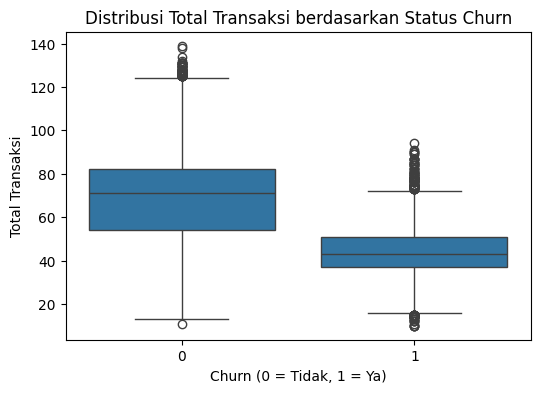

   churn  total_trans_ct
0      0       68.672588
1      1       44.933620
Korelasi Pearson total_trans_ct dengan churn: -0.371


In [ ]:
# Scatter plot (opsional, karena data mungkin diskrit)
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='total_trans_ct', data=df)
plt.title('Distribusi Total Transaksi berdasarkan Status Churn')
plt.xlabel('Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Total Transaksi')
plt.show()

# Rata-rata total_trans_ct berdasarkan churn
mean_trans = df.groupby('churn')['total_trans_ct'].mean().reset_index()
print(mean_trans)

# Korelasi Pearson
corr = df[['total_trans_ct','churn']].corr().iloc[0,1]
print(f"Korelasi Pearson total_trans_ct dengan churn: {corr:.3f}")


                                 Precision    Recall        F1   ROC AUC
Random Guess                      0.199396  0.203077  0.201220  0.523643
Rule (total_trans_ct<threshold)   0.362745  0.569231  0.443114  0.689083
XGBoost                           0.862573  0.907692  0.884558  0.940031


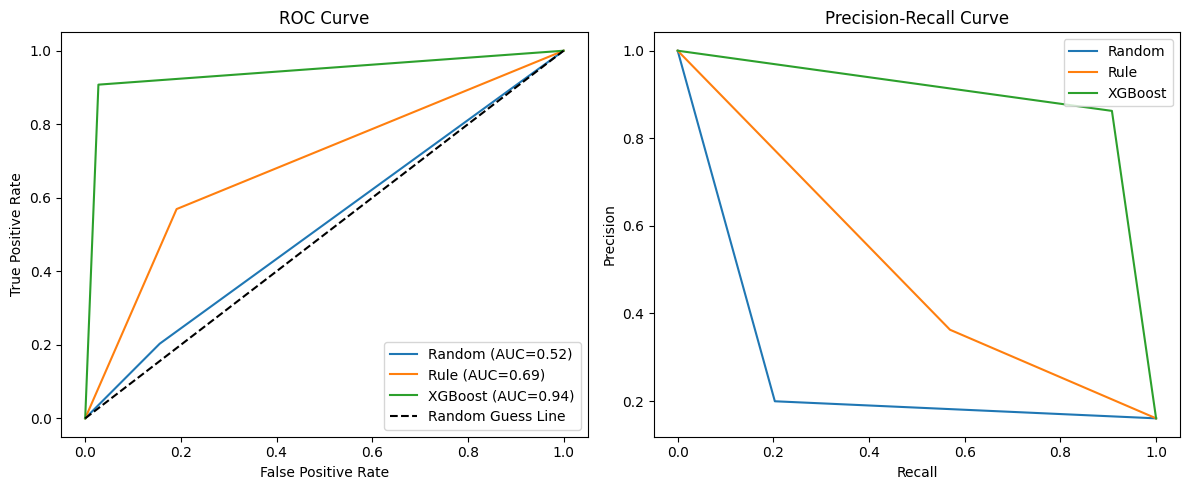

In [ ]:
# 1. Baseline Random Guess
# Probabilitas churn sesuai proporsi di data
p_churn = np.mean(y_test)
y_pred_random = np.random.choice([0, 1], size=len(y_test), p=[1-p_churn, p_churn])

# 2. Baseline Rule Sederhana
# Contoh rule: churn jika total_trans_ct < 45 (threshold bisa kamu sesuaikan)
threshold = 45
y_pred_rule = (X_test['total_trans_ct'] < threshold).astype(int)

# 3. XGBoost Prediction (model sudah ada)
y_pred_xgb = model.predict(X_test_scaled)

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

# 4. Fungsi hitung metrik
def get_metrics(y_true, y_pred):
    return {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred)
    }

# Hitung metrik
metrics_random = get_metrics(y_test, y_pred_random)
metrics_rule = get_metrics(y_test, y_pred_rule)
metrics_xgb = get_metrics(y_test, y_pred_xgb)

# Gabung hasil jadi DataFrame
df_metrics = pd.DataFrame([metrics_random, metrics_rule, metrics_xgb],
                          index=['Random Guess', 'Rule (total_trans_ct<threshold)', 'XGBoost'])

print(df_metrics)

# 5. Visualisasi ROC Curve
plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
for label, preds in [('Random', y_pred_random), ('Rule', y_pred_rule), ('XGBoost', y_pred_xgb)]:
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, preds):.2f})")
plt.plot([0,1], [0,1], 'k--', label='Random Guess Line')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall
plt.subplot(1,2,2)
for label, preds in [('Random', y_pred_random), ('Rule', y_pred_rule), ('XGBoost', y_pred_xgb)]:
    prec, rec, _ = precision_recall_curve(y_test, preds)
    plt.plot(rec, prec, label=label)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

Untuk mengidentifikasi customer yang akan churn dibandingkan
tanpa menggunakan model. Apa metrik yang dapat anda gunakan untuk
membuktikan hal ini? Visualkan!

Di sini saya menggunakan 3 mekanisme:

1. Random Guess -> baseline yang memprediksi churn secara acak tanpa melihat data sama sekali.

Jadi di saya ambil data acak aja menebak churn probabilitas 20%, tidak churn 80%.

sehingga Random Guess ROC AUC ≈ 0.52 (nyaris 0.5 → berarti murni acak)

2. Rule -> konteks ini adalah aturan sederhana berbasis logika bisnis atau pola dari data tanpa menggunakan model machine learning
punya asumsi punya jumlah transaksi dalam 12 bulan terakhir, kurang dari 45 kali, kita prediksi dia akan churn
Kalau transaksi ≥ 45 kali, kita prediksi dia tetap jadi nasabah

3. dengan menggunakan model machine learning XGBoost

Dari ROC Curve & Precision-Recall Curve

ROC Curve:

Sumbu X: False Positive Rate (FPR)

Sumbu Y: True Positive Rate (Recall)

Semakin melengkung ke kiri atas, semakin baik modelnya.

AUC (Area Under Curve) mengukur kemampuan model membedakan churn dan non-churn

  - Random Guess → AUC ≈ 0.52 -> seperti menebak 50% dua sisi saja Yes dan No.
  - Rule → AUC ≈ 0.69 → lumayan lebih baik dari random
  - XGBoost → AUC ≈ 0.94 → sangat baik membedakan churn dan non-churn

Precision-Recall Curve

Precision tinggi → sedikit false positive

Recall tinggi → sedikit false negative

XGBoost punya PR curve paling dekat ke pojok kanan atas → artinya seimbang antara menemukan churn (recall) dan tetap akurat (precision)

ini membuktikan bahwa model menggunakan machine learning:
XGBoost → jauh lebih unggul di semua metrik, terutama AUC dan F1-score → artinya model ini mampu mengidentifikasi churn dengan tingkat kesalahan sangat rendah dan jarang melewatkan churn